# This code runs bfastmonitor over an entire time series data set

In [19]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize 
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [20]:
%matplotlib inline

In [21]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [22]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Output directory name: stored_time_series/Guyana_new


# Select your timeseries folder

In [23]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [24]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    #output_dir = set_output_dir(output_directory_chooser,timeseries_directory)
    #print(output_dir)

/home/dven/downloads/Time_series_2020-09-09_15-45-55/


In [25]:
# set path to dates file
run_dict = {}
for directory in os.listdir(timeseries_directory)[0:-2]:
    
    segment_location = timeseries_directory + directory + "/"
    
    data_list = set_paths(timeseries_directory = segment_location)
    
    run_dict[directory] = data_list
    
    for tile in data_list:
        print(tile)

Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 447 dates, sized 2048 by 2048.
Timeseries class holding 447 dates, sized 197 by 2048.
Timeseries class holding 447 dates, sized 2048 by 2048.
Timeseries class holding 447 dates, sized 197 by 2048.
Timeseries class holding 447 dates, sized 2048 by 2025.
Timeseries class holding 447 dates, sized 197 by 2025.
Data consists of tiles, setting up tiles in 'data_list' 
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 1278 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 1278 by 2048.
Timeseries class holding 368 dates, sized 2048 by 2048.
Timeseries class holding 368 dates, sized 2048 by

In [26]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=False, description='add trend', layout=Layout(height='auto', width='500px…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [27]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

In [28]:
dates = data_list[0].dates
start_date = dates[0] # 0 or 10 does not work.. 100 did ########
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 3153), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2012-01-05', Timestamp('…

In [29]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result

if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")
if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")




In [31]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

In [ ]:
x_block = y_block = block_size_chooser.result


for data_list in run_dict:
    # loading bar
    with tqdm(total=len(data_list)) as pbar1:
        
        
        save_location = base_output_dir + "/" + data_list
        if not os.path.exists(save_location):
            os.makedirs(save_location)
        

        # loop over tile(s) in the data_list
        for counter, tile in enumerate(run_dict[data_list]):
            pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(run_dict[data_list])) )

            tile.set_bfast_parameters(start_monitor = start_monitor, 
                                         end_monitor = end_monitor,
                                         start_hist = start_hist,
                                         freq = freq,
                                         k = k,
                                         hfrac = hfrac,
                                         trend = trend,
                                         level = level,
                                         backend=backend,
                                         verbose=verbose,
                                         device_id=device_id)

            tile.get_bfast_parameters()

            tile.loop_blocks(x_block_size = x_block,
                                y_block_size = y_block)

            tile.log_all_output(output_dir_name=save_location)

            pbar1.update(counter)

    pbar1.close()


Processing tile 1 out of 6:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/64.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/64.0 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
start monitor:  2017-04-03 00:00:00
end monitor:  2020-08-23 00:00:00
start history:  2012-01-05 00:00:00
0 0 256 256



Processing blocks of tile::   3%|▎         | 2/64.0 [00:09<04:57,  4.80s/it]

--- runtime for data initialization:		0.08139920234680176
--- runtime for data transfer (host->device):	0.012833833694458008
--- runtime for data preprocessing:		0.005605936050415039
--- runtime for kernel execution:		0.020925521850585938
--- runtime for data transfer (device->host):	0.003348112106323242
256 0 256 256



Processing blocks of tile::   5%|▍         | 3/64.0 [00:13<04:27,  4.39s/it]

--- runtime for data initialization:		0.0017745494842529297
--- runtime for data transfer (host->device):	0.01267552375793457
--- runtime for data preprocessing:		0.0032393932342529297
--- runtime for kernel execution:		0.020902395248413086
--- runtime for data transfer (device->host):	0.0033416748046875
512 0 256 256



Processing blocks of tile::   6%|▋         | 4/64.0 [00:16<03:57,  3.97s/it]

--- runtime for data initialization:		0.0017769336700439453
--- runtime for data transfer (host->device):	0.012721538543701172
--- runtime for data preprocessing:		0.0032329559326171875
--- runtime for kernel execution:		0.020873308181762695
--- runtime for data transfer (device->host):	0.0031588077545166016
768 0 256 256



Processing blocks of tile::   8%|▊         | 5/64.0 [00:18<03:36,  3.67s/it]

--- runtime for data initialization:		0.0017943382263183594
--- runtime for data transfer (host->device):	0.012653589248657227
--- runtime for data preprocessing:		0.0032176971435546875
--- runtime for kernel execution:		0.021079063415527344
--- runtime for data transfer (device->host):	0.0031805038452148438
1024 0 256 256



Processing blocks of tile::   9%|▉         | 6/64.0 [00:22<03:21,  3.48s/it]

--- runtime for data initialization:		0.001809835433959961
--- runtime for data transfer (host->device):	0.012595891952514648
--- runtime for data preprocessing:		0.0032525062561035156
--- runtime for kernel execution:		0.021037578582763672
--- runtime for data transfer (device->host):	0.003339529037475586
1280 0 256 256



Processing blocks of tile::  11%|█         | 7/64.0 [00:25<03:10,  3.34s/it]

--- runtime for data initialization:		0.0018267631530761719
--- runtime for data transfer (host->device):	0.012728214263916016
--- runtime for data preprocessing:		0.0033121109008789062
--- runtime for kernel execution:		0.02102351188659668
--- runtime for data transfer (device->host):	0.003324747085571289
1536 0 256 256



Processing blocks of tile::  12%|█▎        | 8/64.0 [00:28<03:00,  3.23s/it]

--- runtime for data initialization:		0.0018146038055419922
--- runtime for data transfer (host->device):	0.012742042541503906
--- runtime for data preprocessing:		0.0032508373260498047
--- runtime for kernel execution:		0.021066665649414062
--- runtime for data transfer (device->host):	0.0031816959381103516
1792 0 256 256



Processing blocks of tile::  14%|█▍        | 9/64.0 [00:31<02:54,  3.17s/it]

--- runtime for data initialization:		0.001821279525756836
--- runtime for data transfer (host->device):	0.012764692306518555
--- runtime for data preprocessing:		0.0033431053161621094
--- runtime for kernel execution:		0.021161556243896484
--- runtime for data transfer (device->host):	0.0033278465270996094
0 256 256 256



Processing blocks of tile::  16%|█▌        | 10/64.0 [00:33<02:45,  3.07s/it]

--- runtime for data initialization:		0.0017883777618408203
--- runtime for data transfer (host->device):	0.012671709060668945
--- runtime for data preprocessing:		0.003236055374145508
--- runtime for kernel execution:		0.02090597152709961
--- runtime for data transfer (device->host):	0.0031800270080566406
256 256 256 256



Processing blocks of tile::  17%|█▋        | 11/64.0 [00:36<02:43,  3.08s/it]

--- runtime for data initialization:		0.0018138885498046875
--- runtime for data transfer (host->device):	0.012665510177612305
--- runtime for data preprocessing:		0.0032417774200439453
--- runtime for kernel execution:		0.021091461181640625
--- runtime for data transfer (device->host):	0.0032994747161865234
512 256 256 256



Processing blocks of tile::  19%|█▉        | 12/64.0 [00:40<02:40,  3.08s/it]

--- runtime for data initialization:		0.0018007755279541016
--- runtime for data transfer (host->device):	0.01276850700378418
--- runtime for data preprocessing:		0.0033059120178222656
--- runtime for kernel execution:		0.020894765853881836
--- runtime for data transfer (device->host):	0.003359556198120117
768 256 256 256



Processing blocks of tile::  20%|██        | 13/64.0 [00:43<02:35,  3.04s/it]

--- runtime for data initialization:		0.0017664432525634766
--- runtime for data transfer (host->device):	0.012655496597290039
--- runtime for data preprocessing:		0.003240823745727539
--- runtime for kernel execution:		0.0210421085357666
--- runtime for data transfer (device->host):	0.0033540725708007812
1024 256 256 256



Processing blocks of tile::  22%|██▏       | 14/64.0 [00:46<02:31,  3.03s/it]

--- runtime for data initialization:		0.0018076896667480469
--- runtime for data transfer (host->device):	0.012676239013671875
--- runtime for data preprocessing:		0.003255128860473633
--- runtime for kernel execution:		0.02091693878173828
--- runtime for data transfer (device->host):	0.0033462047576904297
1280 256 256 256



Processing blocks of tile::  23%|██▎       | 15/64.0 [00:48<02:26,  2.99s/it]

--- runtime for data initialization:		0.0017826557159423828
--- runtime for data transfer (host->device):	0.012676239013671875
--- runtime for data preprocessing:		0.0032193660736083984
--- runtime for kernel execution:		0.020897626876831055
--- runtime for data transfer (device->host):	0.003339529037475586
1536 256 256 256



Processing blocks of tile::  25%|██▌       | 16/64.0 [00:51<02:23,  3.00s/it]

--- runtime for data initialization:		0.0017991065979003906
--- runtime for data transfer (host->device):	0.012712717056274414
--- runtime for data preprocessing:		0.003252744674682617
--- runtime for kernel execution:		0.020930767059326172
--- runtime for data transfer (device->host):	0.0033330917358398438
1792 256 256 256



Processing blocks of tile::  27%|██▋       | 17/64.0 [00:54<02:20,  3.00s/it]

--- runtime for data initialization:		0.0017914772033691406
--- runtime for data transfer (host->device):	0.012614965438842773
--- runtime for data preprocessing:		0.003232717514038086
--- runtime for kernel execution:		0.02091240882873535
--- runtime for data transfer (device->host):	0.003339529037475586
0 512 256 256



Processing blocks of tile::  28%|██▊       | 18/64.0 [00:57<02:14,  2.93s/it]

--- runtime for data initialization:		0.001861572265625
--- runtime for data transfer (host->device):	0.012782812118530273
--- runtime for data preprocessing:		0.003349781036376953
--- runtime for kernel execution:		0.021073579788208008
--- runtime for data transfer (device->host):	0.0033059120178222656
256 512 256 256



Processing blocks of tile::  30%|██▉       | 19/64.0 [01:00<02:11,  2.93s/it]

--- runtime for data initialization:		0.001775979995727539
--- runtime for data transfer (host->device):	0.012639284133911133
--- runtime for data preprocessing:		0.003223419189453125
--- runtime for kernel execution:		0.02092576026916504
--- runtime for data transfer (device->host):	0.003339052200317383
512 512 256 256



Processing blocks of tile::  31%|███▏      | 20/64.0 [01:03<02:10,  2.97s/it]

--- runtime for data initialization:		0.0018339157104492188
--- runtime for data transfer (host->device):	0.012853145599365234
--- runtime for data preprocessing:		0.003362894058227539
--- runtime for kernel execution:		0.021037817001342773
--- runtime for data transfer (device->host):	0.0033385753631591797
768 512 256 256



Processing blocks of tile::  33%|███▎      | 21/64.0 [01:06<02:08,  2.99s/it]

--- runtime for data initialization:		0.001794576644897461
--- runtime for data transfer (host->device):	0.012666702270507812
--- runtime for data preprocessing:		0.003222942352294922
--- runtime for kernel execution:		0.020879507064819336
--- runtime for data transfer (device->host):	0.003348112106323242
1024 512 256 256



Processing blocks of tile::  34%|███▍      | 22/64.0 [01:09<02:08,  3.05s/it]

--- runtime for data initialization:		0.0017795562744140625
--- runtime for data transfer (host->device):	0.012633085250854492
--- runtime for data preprocessing:		0.0032286643981933594
--- runtime for kernel execution:		0.02096247673034668
--- runtime for data transfer (device->host):	0.003322124481201172
1280 512 256 256



Processing blocks of tile::  36%|███▌      | 23/64.0 [01:12<02:05,  3.06s/it]

--- runtime for data initialization:		0.0018000602722167969
--- runtime for data transfer (host->device):	0.012593507766723633
--- runtime for data preprocessing:		0.003210783004760742
--- runtime for kernel execution:		0.020907878875732422
--- runtime for data transfer (device->host):	0.003339052200317383
1536 512 256 256



Processing blocks of tile::  38%|███▊      | 24/64.0 [01:16<02:01,  3.05s/it]

--- runtime for data initialization:		0.0017743110656738281
--- runtime for data transfer (host->device):	0.012644767761230469
--- runtime for data preprocessing:		0.003203868865966797
--- runtime for kernel execution:		0.020934581756591797
--- runtime for data transfer (device->host):	0.0033721923828125
1792 512 256 256



Processing blocks of tile::  39%|███▉      | 25/64.0 [01:18<01:57,  3.01s/it]

--- runtime for data initialization:		0.00179290771484375
--- runtime for data transfer (host->device):	0.012592554092407227
--- runtime for data preprocessing:		0.003229856491088867
--- runtime for kernel execution:		0.02094888687133789
--- runtime for data transfer (device->host):	0.0033392906188964844
0 768 256 256



Processing blocks of tile::  41%|████      | 26/64.0 [01:21<01:53,  2.99s/it]

--- runtime for data initialization:		0.0018191337585449219
--- runtime for data transfer (host->device):	0.012642860412597656
--- runtime for data preprocessing:		0.0032219886779785156
--- runtime for kernel execution:		0.020927906036376953
--- runtime for data transfer (device->host):	0.0033435821533203125
256 768 256 256



Processing blocks of tile::  42%|████▏     | 27/64.0 [01:24<01:50,  2.98s/it]

--- runtime for data initialization:		0.0018031597137451172
--- runtime for data transfer (host->device):	0.01272439956665039
--- runtime for data preprocessing:		0.0032150745391845703
--- runtime for kernel execution:		0.021057605743408203
--- runtime for data transfer (device->host):	0.0031790733337402344
512 768 256 256



Processing blocks of tile::  44%|████▍     | 28/64.0 [01:27<01:47,  2.99s/it]

--- runtime for data initialization:		0.0018036365509033203
--- runtime for data transfer (host->device):	0.012677431106567383
--- runtime for data preprocessing:		0.003238677978515625
--- runtime for kernel execution:		0.020956993103027344
--- runtime for data transfer (device->host):	0.0032002925872802734
768 768 256 256



Processing blocks of tile::  45%|████▌     | 29/64.0 [01:30<01:45,  3.01s/it]

--- runtime for data initialization:		0.0017969608306884766
--- runtime for data transfer (host->device):	0.012643098831176758
--- runtime for data preprocessing:		0.0032262802124023438
--- runtime for kernel execution:		0.020920753479003906
--- runtime for data transfer (device->host):	0.003354310989379883
1024 768 256 256



Processing blocks of tile::  47%|████▋     | 30/64.0 [01:33<01:42,  3.01s/it]

--- runtime for data initialization:		0.0017895698547363281
--- runtime for data transfer (host->device):	0.012639045715332031
--- runtime for data preprocessing:		0.0032241344451904297
--- runtime for kernel execution:		0.020898818969726562
--- runtime for data transfer (device->host):	0.0033431053161621094
1280 768 256 256



Processing blocks of tile::  48%|████▊     | 31/64.0 [01:36<01:39,  3.02s/it]

--- runtime for data initialization:		0.0018169879913330078
--- runtime for data transfer (host->device):	0.012631893157958984
--- runtime for data preprocessing:		0.0032122135162353516
--- runtime for kernel execution:		0.0209808349609375
--- runtime for data transfer (device->host):	0.0033593177795410156
1536 768 256 256



Processing blocks of tile::  50%|█████     | 32/64.0 [01:40<01:36,  3.03s/it]

--- runtime for data initialization:		0.001806497573852539
--- runtime for data transfer (host->device):	0.012603282928466797
--- runtime for data preprocessing:		0.0032210350036621094
--- runtime for kernel execution:		0.020919084548950195
--- runtime for data transfer (device->host):	0.003361225128173828
1792 768 256 256



Processing blocks of tile::  52%|█████▏    | 33/64.0 [01:42<01:33,  3.01s/it]

--- runtime for data initialization:		0.0018432140350341797
--- runtime for data transfer (host->device):	0.012677669525146484
--- runtime for data preprocessing:		0.0032148361206054688
--- runtime for kernel execution:		0.02089524269104004
--- runtime for data transfer (device->host):	0.0032236576080322266
0 1024 256 256



Processing blocks of tile::  53%|█████▎    | 34/64.0 [01:45<01:30,  3.00s/it]

--- runtime for data initialization:		0.001800537109375
--- runtime for data transfer (host->device):	0.012733936309814453
--- runtime for data preprocessing:		0.0032460689544677734
--- runtime for kernel execution:		0.020923137664794922
--- runtime for data transfer (device->host):	0.0033516883850097656
256 1024 256 256



Processing blocks of tile::  55%|█████▍    | 35/64.0 [01:49<01:27,  3.02s/it]

--- runtime for data initialization:		0.0017824172973632812
--- runtime for data transfer (host->device):	0.012676715850830078
--- runtime for data preprocessing:		0.0032439231872558594
--- runtime for kernel execution:		0.020931720733642578
--- runtime for data transfer (device->host):	0.0033354759216308594
512 1024 256 256



Processing blocks of tile::  56%|█████▋    | 36/64.0 [01:52<01:24,  3.02s/it]

--- runtime for data initialization:		0.0018134117126464844
--- runtime for data transfer (host->device):	0.012689590454101562
--- runtime for data preprocessing:		0.0032510757446289062
--- runtime for kernel execution:		0.02090144157409668
--- runtime for data transfer (device->host):	0.003341197967529297
768 1024 256 256



Processing blocks of tile::  58%|█████▊    | 37/64.0 [01:55<01:22,  3.04s/it]

--- runtime for data initialization:		0.0017888545989990234
--- runtime for data transfer (host->device):	0.012633323669433594
--- runtime for data preprocessing:		0.0032219886779785156
--- runtime for kernel execution:		0.02106022834777832
--- runtime for data transfer (device->host):	0.0033295154571533203
1024 1024 256 256



Processing blocks of tile::  59%|█████▉    | 38/64.0 [01:58<01:19,  3.04s/it]

--- runtime for data initialization:		0.0018262863159179688
--- runtime for data transfer (host->device):	0.01269841194152832
--- runtime for data preprocessing:		0.0032432079315185547
--- runtime for kernel execution:		0.020960092544555664
--- runtime for data transfer (device->host):	0.003346681594848633
1280 1024 256 256



Processing blocks of tile::  61%|██████    | 39/64.0 [02:01<01:16,  3.05s/it]

--- runtime for data initialization:		0.0017857551574707031
--- runtime for data transfer (host->device):	0.012634754180908203
--- runtime for data preprocessing:		0.0032775402069091797
--- runtime for kernel execution:		0.021077871322631836
--- runtime for data transfer (device->host):	0.003324747085571289
1536 1024 256 256



Processing blocks of tile::  62%|██████▎   | 40/64.0 [02:04<01:12,  3.02s/it]

--- runtime for data initialization:		0.0018072128295898438
--- runtime for data transfer (host->device):	0.012627363204956055
--- runtime for data preprocessing:		0.003226757049560547
--- runtime for kernel execution:		0.020929336547851562
--- runtime for data transfer (device->host):	0.003377199172973633
1792 1024 256 256



Processing blocks of tile::  64%|██████▍   | 41/64.0 [02:07<01:09,  3.02s/it]

--- runtime for data initialization:		0.0018048286437988281
--- runtime for data transfer (host->device):	0.012691974639892578
--- runtime for data preprocessing:		0.003253936767578125
--- runtime for kernel execution:		0.021078109741210938
--- runtime for data transfer (device->host):	0.0033643245697021484
0 1280 256 256



Processing blocks of tile::  66%|██████▌   | 42/64.0 [02:10<01:06,  3.01s/it]

--- runtime for data initialization:		0.0017807483673095703
--- runtime for data transfer (host->device):	0.012678146362304688
--- runtime for data preprocessing:		0.0032308101654052734
--- runtime for kernel execution:		0.0210721492767334
--- runtime for data transfer (device->host):	0.003342151641845703
256 1280 256 256



Processing blocks of tile::  67%|██████▋   | 43/64.0 [02:13<01:02,  2.99s/it]

--- runtime for data initialization:		0.0017926692962646484
--- runtime for data transfer (host->device):	0.012703418731689453
--- runtime for data preprocessing:		0.003223419189453125
--- runtime for kernel execution:		0.02091836929321289
--- runtime for data transfer (device->host):	0.003344297409057617
512 1280 256 256



Processing blocks of tile::  69%|██████▉   | 44/64.0 [02:16<01:00,  3.02s/it]

--- runtime for data initialization:		0.0017979145050048828
--- runtime for data transfer (host->device):	0.012617111206054688
--- runtime for data preprocessing:		0.0032355785369873047
--- runtime for kernel execution:		0.02087998390197754
--- runtime for data transfer (device->host):	0.003204345703125
768 1280 256 256



Processing blocks of tile::  70%|███████   | 45/64.0 [02:19<00:57,  3.01s/it]

--- runtime for data initialization:		0.001852273941040039
--- runtime for data transfer (host->device):	0.012708902359008789
--- runtime for data preprocessing:		0.0032494068145751953
--- runtime for kernel execution:		0.02108454704284668
--- runtime for data transfer (device->host):	0.0033576488494873047
1024 1280 256 256



Processing blocks of tile::  72%|███████▏  | 46/64.0 [02:22<00:53,  2.99s/it]

--- runtime for data initialization:		0.0018398761749267578
--- runtime for data transfer (host->device):	0.012772798538208008
--- runtime for data preprocessing:		0.0032553672790527344
--- runtime for kernel execution:		0.021090269088745117
--- runtime for data transfer (device->host):	0.003357410430908203
1280 1280 256 256



Processing blocks of tile::  73%|███████▎  | 47/64.0 [02:25<00:50,  2.97s/it]

--- runtime for data initialization:		0.001786947250366211
--- runtime for data transfer (host->device):	0.012732982635498047
--- runtime for data preprocessing:		0.0032215118408203125
--- runtime for kernel execution:		0.02108001708984375
--- runtime for data transfer (device->host):	0.003365039825439453
1536 1280 256 256



Processing blocks of tile::  75%|███████▌  | 48/64.0 [02:28<00:47,  2.96s/it]

--- runtime for data initialization:		0.0018286705017089844
--- runtime for data transfer (host->device):	0.01266622543334961
--- runtime for data preprocessing:		0.0032243728637695312
--- runtime for kernel execution:		0.020930767059326172
--- runtime for data transfer (device->host):	0.0033385753631591797
1792 1280 256 256



Processing blocks of tile::  77%|███████▋  | 49/64.0 [02:31<00:44,  2.97s/it]

--- runtime for data initialization:		0.0018453598022460938
--- runtime for data transfer (host->device):	0.012713909149169922
--- runtime for data preprocessing:		0.0032508373260498047
--- runtime for kernel execution:		0.020924806594848633
--- runtime for data transfer (device->host):	0.0033349990844726562
0 1536 256 256



Processing blocks of tile::  78%|███████▊  | 50/64.0 [02:33<00:41,  2.95s/it]

--- runtime for data initialization:		0.0018031597137451172
--- runtime for data transfer (host->device):	0.012788057327270508
--- runtime for data preprocessing:		0.003297090530395508
--- runtime for kernel execution:		0.02089858055114746
--- runtime for data transfer (device->host):	0.0033271312713623047
256 1536 256 256



Processing blocks of tile::  80%|███████▉  | 51/64.0 [02:36<00:38,  2.98s/it]

--- runtime for data initialization:		0.0017948150634765625
--- runtime for data transfer (host->device):	0.012643575668334961
--- runtime for data preprocessing:		0.0032384395599365234
--- runtime for kernel execution:		0.020964860916137695
--- runtime for data transfer (device->host):	0.0033521652221679688
512 1536 256 256



Processing blocks of tile::  81%|████████▏ | 52/64.0 [02:39<00:35,  2.98s/it]

--- runtime for data initialization:		0.0018041133880615234
--- runtime for data transfer (host->device):	0.012750864028930664
--- runtime for data preprocessing:		0.003323793411254883
--- runtime for kernel execution:		0.021104812622070312
--- runtime for data transfer (device->host):	0.0031490325927734375
768 1536 256 256



Processing blocks of tile::  83%|████████▎ | 53/64.0 [02:42<00:32,  2.97s/it]

--- runtime for data initialization:		0.0018150806427001953
--- runtime for data transfer (host->device):	0.012834548950195312
--- runtime for data preprocessing:		0.003362417221069336
--- runtime for kernel execution:		0.021126508712768555
--- runtime for data transfer (device->host):	0.003322124481201172
1024 1536 256 256



Processing blocks of tile::  84%|████████▍ | 54/64.0 [02:45<00:29,  2.96s/it]

--- runtime for data initialization:		0.0018453598022460938
--- runtime for data transfer (host->device):	0.012667179107666016
--- runtime for data preprocessing:		0.003247499465942383
--- runtime for kernel execution:		0.02115774154663086
--- runtime for data transfer (device->host):	0.0033431053161621094
1280 1536 256 256



Processing blocks of tile::  86%|████████▌ | 55/64.0 [02:48<00:26,  2.97s/it]

--- runtime for data initialization:		0.001779794692993164
--- runtime for data transfer (host->device):	0.012670278549194336
--- runtime for data preprocessing:		0.0032351016998291016
--- runtime for kernel execution:		0.020964384078979492
--- runtime for data transfer (device->host):	0.003342151641845703
1536 1536 256 256



Processing blocks of tile::  88%|████████▊ | 56/64.0 [02:51<00:23,  2.97s/it]

--- runtime for data initialization:		0.0017828941345214844
--- runtime for data transfer (host->device):	0.01264643669128418
--- runtime for data preprocessing:		0.003261566162109375
--- runtime for kernel execution:		0.020939350128173828
--- runtime for data transfer (device->host):	0.003251791000366211
1792 1536 256 256



Processing blocks of tile::  89%|████████▉ | 57/64.0 [02:54<00:20,  2.98s/it]

--- runtime for data initialization:		0.001773834228515625
--- runtime for data transfer (host->device):	0.012713193893432617
--- runtime for data preprocessing:		0.003279447555541992
--- runtime for kernel execution:		0.021068811416625977
--- runtime for data transfer (device->host):	0.003289461135864258
0 1792 256 256



Processing blocks of tile::  91%|█████████ | 58/64.0 [02:57<00:17,  2.95s/it]

--- runtime for data initialization:		0.0018537044525146484
--- runtime for data transfer (host->device):	0.012698173522949219
--- runtime for data preprocessing:		0.0032241344451904297
--- runtime for kernel execution:		0.02107715606689453
--- runtime for data transfer (device->host):	0.003199338912963867
256 1792 256 256



Processing blocks of tile::  92%|█████████▏| 59/64.0 [03:00<00:14,  2.95s/it]

--- runtime for data initialization:		0.0017828941345214844
--- runtime for data transfer (host->device):	0.012620925903320312
--- runtime for data preprocessing:		0.003247499465942383
--- runtime for kernel execution:		0.02093982696533203
--- runtime for data transfer (device->host):	0.0033576488494873047
512 1792 256 256



Processing blocks of tile::  94%|█████████▍| 60/64.0 [03:03<00:11,  2.95s/it]

--- runtime for data initialization:		0.0018227100372314453
--- runtime for data transfer (host->device):	0.012697219848632812
--- runtime for data preprocessing:		0.003254413604736328
--- runtime for kernel execution:		0.02093815803527832
--- runtime for data transfer (device->host):	0.00333404541015625
768 1792 256 256



Processing blocks of tile::  95%|█████████▌| 61/64.0 [03:06<00:09,  3.02s/it]

--- runtime for data initialization:		0.001798391342163086
--- runtime for data transfer (host->device):	0.012666702270507812
--- runtime for data preprocessing:		0.0032262802124023438
--- runtime for kernel execution:		0.020914793014526367
--- runtime for data transfer (device->host):	0.0033674240112304688
1024 1792 256 256



Processing blocks of tile::  97%|█████████▋| 62/64.0 [03:09<00:05,  2.99s/it]

--- runtime for data initialization:		0.001798391342163086
--- runtime for data transfer (host->device):	0.012604951858520508
--- runtime for data preprocessing:		0.0032083988189697266
--- runtime for kernel execution:		0.02106952667236328
--- runtime for data transfer (device->host):	0.003330707550048828
1280 1792 256 256



Processing blocks of tile::  98%|█████████▊| 63/64.0 [03:12<00:02,  2.97s/it]

--- runtime for data initialization:		0.0017886161804199219
--- runtime for data transfer (host->device):	0.01270437240600586
--- runtime for data preprocessing:		0.0032744407653808594
--- runtime for kernel execution:		0.02110433578491211
--- runtime for data transfer (device->host):	0.003152608871459961
1536 1792 256 256



Processing blocks of tile:: 100%|██████████| 64/64.0 [03:15<00:00,  2.97s/it]

--- runtime for data initialization:		0.001817464828491211
--- runtime for data transfer (host->device):	0.012761116027832031
--- runtime for data preprocessing:		0.0032341480255126953
--- runtime for kernel execution:		0.02108287811279297
--- runtime for data transfer (device->host):	0.003361225128173828
1792 1792 256 256


Processing blocks of tile:: 100%|██████████| 64/64.0 [03:18<00:00,  3.10s/it]

--- runtime for data initialization:		0.001871347427368164
--- runtime for data transfer (host->device):	0.012716531753540039
--- runtime for data preprocessing:		0.0032219886779785156
--- runtime for kernel execution:		0.021088361740112305
--- runtime for data transfer (device->host):	0.003360748291015625
Fitting model over all blocks took 198.506502866745 seconds.



Processing tile 2 out of 6:   0%|          | 0/1 [03:18<?, ?it/s]
Processing blocks of tile:: : 7it [00:18,  2.70s/it]                           

--- runtime for data initialization:		0.0019447803497314453
--- runtime for data transfer (host->device):	0.00988316535949707
--- runtime for data preprocessing:		0.0028679370880126953
--- runtime for kernel execution:		0.016333580017089844
--- runtime for data transfer (device->host):	0.002560138702392578
0 1536 197 256



Processing blocks of tile:: : 8it [00:21,  2.72s/it]

--- runtime for data initialization:		0.0017726421356201172
--- runtime for data transfer (host->device):	0.00987696647644043
--- runtime for data preprocessing:		0.0028917789459228516
--- runtime for kernel execution:		0.0163419246673584
--- runtime for data transfer (device->host):	0.0025429725646972656
0 1792 197 256


Processing blocks of tile:: : 8it [00:24,  3.02s/it]
Processing tile 3 out of 6: 100%|██████████| 1/1 [03:43<00:00, 24.30s/it]
  0%|          | 0/64.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/64.0 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0018045902252197266
--- runtime for data transfer (host->device):	0.010039329528808594
--- runtime for data preprocessing:		0.0029363632202148438
--- runtime for kernel execution:		0.016459226608276367
--- runtime for data transfer (device->host):	0.0025429725646972656
Fitting model over all blocks took 24.170021057128906 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verb


Processing blocks of tile::   3%|▎         | 2/64.0 [00:04<02:31,  2.44s/it]

--- runtime for data initialization:		0.0018157958984375
--- runtime for data transfer (host->device):	0.01270437240600586
--- runtime for data preprocessing:		0.00322723388671875
--- runtime for kernel execution:		0.021084070205688477
--- runtime for data transfer (device->host):	0.0033249855041503906
256 0 256 256



Processing blocks of tile::   5%|▍         | 3/64.0 [00:07<02:38,  2.60s/it]

--- runtime for data initialization:		0.0017745494842529297
--- runtime for data transfer (host->device):	0.01260828971862793
--- runtime for data preprocessing:		0.0032470226287841797
--- runtime for kernel execution:		0.020949125289916992
--- runtime for data transfer (device->host):	0.0033414363861083984
512 0 256 256



Processing blocks of tile::   6%|▋         | 4/64.0 [00:10<02:42,  2.70s/it]

--- runtime for data initialization:		0.0017735958099365234
--- runtime for data transfer (host->device):	0.012590885162353516
--- runtime for data preprocessing:		0.0032346248626708984
--- runtime for kernel execution:		0.020940303802490234
--- runtime for data transfer (device->host):	0.0033538341522216797
768 0 256 256



Processing blocks of tile::   8%|▊         | 5/64.0 [00:13<02:45,  2.80s/it]

--- runtime for data initialization:		0.0017940998077392578
--- runtime for data transfer (host->device):	0.012644767761230469
--- runtime for data preprocessing:		0.0032227039337158203
--- runtime for kernel execution:		0.02092432975769043
--- runtime for data transfer (device->host):	0.0033473968505859375
1024 0 256 256



Processing blocks of tile::   9%|▉         | 6/64.0 [00:16<02:45,  2.85s/it]

--- runtime for data initialization:		0.0017774105072021484
--- runtime for data transfer (host->device):	0.012651205062866211
--- runtime for data preprocessing:		0.003223896026611328
--- runtime for kernel execution:		0.020931482315063477
--- runtime for data transfer (device->host):	0.003375530242919922
1280 0 256 256



Processing blocks of tile::  11%|█         | 7/64.0 [00:19<02:45,  2.90s/it]

--- runtime for data initialization:		0.0018205642700195312
--- runtime for data transfer (host->device):	0.012729167938232422
--- runtime for data preprocessing:		0.003290414810180664
--- runtime for kernel execution:		0.021126747131347656
--- runtime for data transfer (device->host):	0.0033164024353027344
1536 0 256 256



Processing blocks of tile::  12%|█▎        | 8/64.0 [00:22<02:45,  2.95s/it]

--- runtime for data initialization:		0.0018122196197509766
--- runtime for data transfer (host->device):	0.012618303298950195
--- runtime for data preprocessing:		0.0032362937927246094
--- runtime for kernel execution:		0.020917654037475586
--- runtime for data transfer (device->host):	0.003343343734741211
1792 0 256 256



Processing blocks of tile::  14%|█▍        | 9/64.0 [00:25<02:43,  2.98s/it]

--- runtime for data initialization:		0.0017762184143066406
--- runtime for data transfer (host->device):	0.012624979019165039
--- runtime for data preprocessing:		0.0032415390014648438
--- runtime for kernel execution:		0.020910978317260742
--- runtime for data transfer (device->host):	0.0033485889434814453
0 256 256 256



Processing blocks of tile::  16%|█▌        | 10/64.0 [00:28<02:40,  2.98s/it]

--- runtime for data initialization:		0.0017702579498291016
--- runtime for data transfer (host->device):	0.012705326080322266
--- runtime for data preprocessing:		0.003238201141357422
--- runtime for kernel execution:		0.021114587783813477
--- runtime for data transfer (device->host):	0.0033464431762695312
256 256 256 256



Processing blocks of tile::  17%|█▋        | 11/64.0 [00:31<02:37,  2.97s/it]

--- runtime for data initialization:		0.0018172264099121094
--- runtime for data transfer (host->device):	0.01267242431640625
--- runtime for data preprocessing:		0.003251314163208008
--- runtime for kernel execution:		0.02094554901123047
--- runtime for data transfer (device->host):	0.0033502578735351562
512 256 256 256



Processing blocks of tile::  19%|█▉        | 12/64.0 [00:34<02:35,  2.99s/it]

--- runtime for data initialization:		0.0018742084503173828
--- runtime for data transfer (host->device):	0.012650489807128906
--- runtime for data preprocessing:		0.003239870071411133
--- runtime for kernel execution:		0.020934104919433594
--- runtime for data transfer (device->host):	0.003345489501953125
768 256 256 256



Processing blocks of tile::  20%|██        | 13/64.0 [00:37<02:33,  3.00s/it]

--- runtime for data initialization:		0.0018100738525390625
--- runtime for data transfer (host->device):	0.012653589248657227
--- runtime for data preprocessing:		0.003226041793823242
--- runtime for kernel execution:		0.021091461181640625
--- runtime for data transfer (device->host):	0.0031795501708984375
1024 256 256 256



Processing blocks of tile::  22%|██▏       | 14/64.0 [00:40<02:31,  3.03s/it]

--- runtime for data initialization:		0.001809835433959961
--- runtime for data transfer (host->device):	0.01271367073059082
--- runtime for data preprocessing:		0.003232240676879883
--- runtime for kernel execution:		0.02088141441345215
--- runtime for data transfer (device->host):	0.003203153610229492
1280 256 256 256



Processing blocks of tile::  23%|██▎       | 15/64.0 [00:43<02:27,  3.02s/it]

--- runtime for data initialization:		0.0018107891082763672
--- runtime for data transfer (host->device):	0.01264333724975586
--- runtime for data preprocessing:		0.003238677978515625
--- runtime for kernel execution:		0.021026134490966797
--- runtime for data transfer (device->host):	0.003353118896484375
1536 256 256 256



Processing blocks of tile::  25%|██▌       | 16/64.0 [00:46<02:24,  3.01s/it]

--- runtime for data initialization:		0.0018162727355957031
--- runtime for data transfer (host->device):	0.012641668319702148
--- runtime for data preprocessing:		0.0032491683959960938
--- runtime for kernel execution:		0.02092742919921875
--- runtime for data transfer (device->host):	0.0033490657806396484
1792 256 256 256



Processing blocks of tile::  27%|██▋       | 17/64.0 [00:49<02:21,  3.01s/it]

--- runtime for data initialization:		0.0017957687377929688
--- runtime for data transfer (host->device):	0.012691020965576172
--- runtime for data preprocessing:		0.0032308101654052734
--- runtime for kernel execution:		0.021141767501831055
--- runtime for data transfer (device->host):	0.0031719207763671875
0 512 256 256



Processing blocks of tile::  28%|██▊       | 18/64.0 [00:53<02:20,  3.06s/it]

--- runtime for data initialization:		0.0018019676208496094
--- runtime for data transfer (host->device):	0.012699365615844727
--- runtime for data preprocessing:		0.0032312870025634766
--- runtime for kernel execution:		0.021075963973999023
--- runtime for data transfer (device->host):	0.003349781036376953
256 512 256 256



Processing blocks of tile::  30%|██▉       | 19/64.0 [00:55<02:14,  2.98s/it]

--- runtime for data initialization:		0.0017819404602050781
--- runtime for data transfer (host->device):	0.012657642364501953
--- runtime for data preprocessing:		0.0032453536987304688
--- runtime for kernel execution:		0.020926237106323242
--- runtime for data transfer (device->host):	0.003350973129272461
512 512 256 256



Processing blocks of tile::  31%|███▏      | 20/64.0 [00:58<02:10,  2.96s/it]

--- runtime for data initialization:		0.001779317855834961
--- runtime for data transfer (host->device):	0.012649774551391602
--- runtime for data preprocessing:		0.003237009048461914
--- runtime for kernel execution:		0.020936012268066406
--- runtime for data transfer (device->host):	0.0033576488494873047
768 512 256 256



Processing blocks of tile::  33%|███▎      | 21/64.0 [01:01<02:07,  2.96s/it]

--- runtime for data initialization:		0.0017790794372558594
--- runtime for data transfer (host->device):	0.012714862823486328
--- runtime for data preprocessing:		0.003237009048461914
--- runtime for kernel execution:		0.02111673355102539
--- runtime for data transfer (device->host):	0.003360271453857422
1024 512 256 256



Processing blocks of tile::  34%|███▍      | 22/64.0 [01:04<02:04,  2.96s/it]

--- runtime for data initialization:		0.0018520355224609375
--- runtime for data transfer (host->device):	0.012704610824584961
--- runtime for data preprocessing:		0.0032317638397216797
--- runtime for kernel execution:		0.021081209182739258
--- runtime for data transfer (device->host):	0.0031943321228027344
1280 512 256 256



Processing blocks of tile::  36%|███▌      | 23/64.0 [01:07<02:01,  2.96s/it]

--- runtime for data initialization:		0.00185394287109375
--- runtime for data transfer (host->device):	0.012737751007080078
--- runtime for data preprocessing:		0.0032601356506347656
--- runtime for kernel execution:		0.021126985549926758
--- runtime for data transfer (device->host):	0.0031745433807373047
1536 512 256 256



Processing blocks of tile::  38%|███▊      | 24/64.0 [01:10<01:58,  2.96s/it]

--- runtime for data initialization:		0.0017819404602050781
--- runtime for data transfer (host->device):	0.01264190673828125
--- runtime for data preprocessing:		0.0032520294189453125
--- runtime for kernel execution:		0.020934104919433594
--- runtime for data transfer (device->host):	0.003366708755493164
1792 512 256 256



Processing blocks of tile::  39%|███▉      | 25/64.0 [01:13<01:55,  2.97s/it]

--- runtime for data initialization:		0.0018253326416015625
--- runtime for data transfer (host->device):	0.012628316879272461
--- runtime for data preprocessing:		0.0032281875610351562
--- runtime for kernel execution:		0.02092123031616211
--- runtime for data transfer (device->host):	0.003356456756591797
0 768 256 256



Processing blocks of tile::  41%|████      | 26/64.0 [01:16<01:54,  3.02s/it]

--- runtime for data initialization:		0.0017838478088378906
--- runtime for data transfer (host->device):	0.01267385482788086
--- runtime for data preprocessing:		0.0032291412353515625
--- runtime for kernel execution:		0.021080732345581055
--- runtime for data transfer (device->host):	0.0033304691314697266
256 768 256 256



Processing blocks of tile::  42%|████▏     | 27/64.0 [01:19<01:49,  2.96s/it]

--- runtime for data initialization:		0.0018258094787597656
--- runtime for data transfer (host->device):	0.01264643669128418
--- runtime for data preprocessing:		0.0032320022583007812
--- runtime for kernel execution:		0.0209505558013916
--- runtime for data transfer (device->host):	0.003334522247314453
512 768 256 256



Processing blocks of tile::  44%|████▍     | 28/64.0 [01:22<01:45,  2.92s/it]

--- runtime for data initialization:		0.0018010139465332031
--- runtime for data transfer (host->device):	0.012684822082519531
--- runtime for data preprocessing:		0.003252267837524414
--- runtime for kernel execution:		0.02093958854675293
--- runtime for data transfer (device->host):	0.0033447742462158203
768 768 256 256



Processing blocks of tile::  45%|████▌     | 29/64.0 [01:25<01:42,  2.92s/it]

--- runtime for data initialization:		0.001821279525756836
--- runtime for data transfer (host->device):	0.012628793716430664
--- runtime for data preprocessing:		0.003248453140258789
--- runtime for kernel execution:		0.020913362503051758
--- runtime for data transfer (device->host):	0.003347158432006836
1024 768 256 256



Processing blocks of tile::  47%|████▋     | 30/64.0 [01:28<01:39,  2.92s/it]

--- runtime for data initialization:		0.0017998218536376953
--- runtime for data transfer (host->device):	0.012675046920776367
--- runtime for data preprocessing:		0.003239870071411133
--- runtime for kernel execution:		0.02107548713684082
--- runtime for data transfer (device->host):	0.0033621788024902344
1280 768 256 256



Processing blocks of tile::  48%|████▊     | 31/64.0 [01:31<01:36,  2.92s/it]

--- runtime for data initialization:		0.0017879009246826172
--- runtime for data transfer (host->device):	0.01268911361694336
--- runtime for data preprocessing:		0.0032503604888916016
--- runtime for kernel execution:		0.021103858947753906
--- runtime for data transfer (device->host):	0.003359556198120117
1536 768 256 256



Processing blocks of tile::  50%|█████     | 32/64.0 [01:34<01:33,  2.93s/it]

--- runtime for data initialization:		0.0018115043640136719
--- runtime for data transfer (host->device):	0.01271367073059082
--- runtime for data preprocessing:		0.003268718719482422
--- runtime for kernel execution:		0.02109241485595703
--- runtime for data transfer (device->host):	0.0033712387084960938
1792 768 256 256



Processing blocks of tile::  52%|█████▏    | 33/64.0 [01:37<01:30,  2.92s/it]

--- runtime for data initialization:		0.001806020736694336
--- runtime for data transfer (host->device):	0.012594938278198242
--- runtime for data preprocessing:		0.003247976303100586
--- runtime for kernel execution:		0.020936012268066406
--- runtime for data transfer (device->host):	0.003348827362060547
0 1024 256 256



Processing blocks of tile::  53%|█████▎    | 34/64.0 [01:40<01:30,  3.00s/it]

--- runtime for data initialization:		0.0018618106842041016
--- runtime for data transfer (host->device):	0.01266622543334961
--- runtime for data preprocessing:		0.003232240676879883
--- runtime for kernel execution:		0.021075725555419922
--- runtime for data transfer (device->host):	0.003368377685546875
256 1024 256 256



Processing blocks of tile::  55%|█████▍    | 35/64.0 [01:43<01:28,  3.04s/it]

--- runtime for data initialization:		0.0017876625061035156
--- runtime for data transfer (host->device):	0.01272130012512207
--- runtime for data preprocessing:		0.0032808780670166016
--- runtime for kernel execution:		0.021104812622070312
--- runtime for data transfer (device->host):	0.0031502246856689453
512 1024 256 256



Processing blocks of tile::  56%|█████▋    | 36/64.0 [01:46<01:23,  2.97s/it]

--- runtime for data initialization:		0.001850128173828125
--- runtime for data transfer (host->device):	0.012633562088012695
--- runtime for data preprocessing:		0.0032227039337158203
--- runtime for kernel execution:		0.020914554595947266
--- runtime for data transfer (device->host):	0.0033555030822753906
768 1024 256 256



Processing blocks of tile::  58%|█████▊    | 37/64.0 [01:49<01:20,  2.97s/it]

--- runtime for data initialization:		0.0018415451049804688
--- runtime for data transfer (host->device):	0.01289057731628418
--- runtime for data preprocessing:		0.0034072399139404297
--- runtime for kernel execution:		0.021175146102905273
--- runtime for data transfer (device->host):	0.0031223297119140625
1024 1024 256 256



Processing blocks of tile::  59%|█████▉    | 38/64.0 [01:52<01:17,  2.97s/it]

--- runtime for data initialization:		0.0017964839935302734
--- runtime for data transfer (host->device):	0.012644052505493164
--- runtime for data preprocessing:		0.0032296180725097656
--- runtime for kernel execution:		0.020961284637451172
--- runtime for data transfer (device->host):	0.00335693359375
1280 1024 256 256



Processing blocks of tile::  61%|██████    | 39/64.0 [01:55<01:13,  2.96s/it]

--- runtime for data initialization:		0.0018084049224853516
--- runtime for data transfer (host->device):	0.012604951858520508
--- runtime for data preprocessing:		0.0032372474670410156
--- runtime for kernel execution:		0.020966291427612305
--- runtime for data transfer (device->host):	0.003354310989379883
1536 1024 256 256



Processing blocks of tile::  62%|██████▎   | 40/64.0 [01:58<01:10,  2.96s/it]

--- runtime for data initialization:		0.0017838478088378906
--- runtime for data transfer (host->device):	0.012620687484741211
--- runtime for data preprocessing:		0.0032846927642822266
--- runtime for kernel execution:		0.02089095115661621
--- runtime for data transfer (device->host):	0.0033349990844726562
1792 1024 256 256



Processing blocks of tile::  64%|██████▍   | 41/64.0 [02:01<01:08,  2.96s/it]

--- runtime for data initialization:		0.0018045902252197266
--- runtime for data transfer (host->device):	0.012684822082519531
--- runtime for data preprocessing:		0.0032792091369628906
--- runtime for kernel execution:		0.021086931228637695
--- runtime for data transfer (device->host):	0.003220796585083008
0 1280 256 256



Processing blocks of tile::  66%|██████▌   | 42/64.0 [02:04<01:06,  3.03s/it]

--- runtime for data initialization:		0.0018572807312011719
--- runtime for data transfer (host->device):	0.012624740600585938
--- runtime for data preprocessing:		0.003230571746826172
--- runtime for kernel execution:		0.02095770835876465
--- runtime for data transfer (device->host):	0.0033524036407470703
256 1280 256 256



Processing blocks of tile::  67%|██████▋   | 43/64.0 [02:07<01:04,  3.06s/it]

--- runtime for data initialization:		0.0017828941345214844
--- runtime for data transfer (host->device):	0.01270437240600586
--- runtime for data preprocessing:		0.0032444000244140625
--- runtime for kernel execution:		0.021113157272338867
--- runtime for data transfer (device->host):	0.0033311843872070312
512 1280 256 256



Processing blocks of tile::  69%|██████▉   | 44/64.0 [02:10<01:01,  3.08s/it]

--- runtime for data initialization:		0.001783609390258789
--- runtime for data transfer (host->device):	0.012677431106567383
--- runtime for data preprocessing:		0.003223896026611328
--- runtime for kernel execution:		0.020951271057128906
--- runtime for data transfer (device->host):	0.0033495426177978516
768 1280 256 256



Processing blocks of tile::  70%|███████   | 45/64.0 [02:13<00:56,  2.96s/it]

--- runtime for data initialization:		0.0018706321716308594
--- runtime for data transfer (host->device):	0.012633562088012695
--- runtime for data preprocessing:		0.0032274723052978516
--- runtime for kernel execution:		0.020936012268066406
--- runtime for data transfer (device->host):	0.003343820571899414
1024 1280 256 256



Processing blocks of tile::  72%|███████▏  | 46/64.0 [02:16<00:53,  2.95s/it]

--- runtime for data initialization:		0.0018000602722167969
--- runtime for data transfer (host->device):	0.012642145156860352
--- runtime for data preprocessing:		0.0032405853271484375
--- runtime for kernel execution:		0.02096247673034668
--- runtime for data transfer (device->host):	0.003341197967529297
1280 1280 256 256



Processing blocks of tile::  73%|███████▎  | 47/64.0 [02:19<00:50,  2.95s/it]

--- runtime for data initialization:		0.0017864704132080078
--- runtime for data transfer (host->device):	0.012751340866088867
--- runtime for data preprocessing:		0.003293275833129883
--- runtime for kernel execution:		0.02110004425048828
--- runtime for data transfer (device->host):	0.0031735897064208984
1536 1280 256 256



Processing blocks of tile::  75%|███████▌  | 48/64.0 [02:22<00:47,  2.99s/it]

--- runtime for data initialization:		0.0018305778503417969
--- runtime for data transfer (host->device):	0.01263427734375
--- runtime for data preprocessing:		0.003237009048461914
--- runtime for kernel execution:		0.020945310592651367
--- runtime for data transfer (device->host):	0.003358602523803711
1792 1280 256 256



Processing blocks of tile::  77%|███████▋  | 49/64.0 [02:25<00:44,  2.97s/it]

--- runtime for data initialization:		0.00177764892578125
--- runtime for data transfer (host->device):	0.012764930725097656
--- runtime for data preprocessing:		0.0032711029052734375
--- runtime for kernel execution:		0.020917177200317383
--- runtime for data transfer (device->host):	0.0031991004943847656
0 1536 256 256



Processing blocks of tile::  78%|███████▊  | 50/64.0 [02:28<00:42,  3.04s/it]

--- runtime for data initialization:		0.001809835433959961
--- runtime for data transfer (host->device):	0.01272273063659668
--- runtime for data preprocessing:		0.003269195556640625
--- runtime for kernel execution:		0.020914554595947266
--- runtime for data transfer (device->host):	0.0032057762145996094
256 1536 256 256



Processing blocks of tile::  80%|███████▉  | 51/64.0 [02:31<00:40,  3.08s/it]

--- runtime for data initialization:		0.001809835433959961
--- runtime for data transfer (host->device):	0.012639284133911133
--- runtime for data preprocessing:		0.0032265186309814453
--- runtime for kernel execution:		0.020917654037475586
--- runtime for data transfer (device->host):	0.0033416748046875
512 1536 256 256



Processing blocks of tile::  81%|████████▏ | 52/64.0 [02:34<00:37,  3.12s/it]

--- runtime for data initialization:		0.0018041133880615234
--- runtime for data transfer (host->device):	0.012724876403808594
--- runtime for data preprocessing:		0.003251791000366211
--- runtime for kernel execution:		0.021074771881103516
--- runtime for data transfer (device->host):	0.0033550262451171875
768 1536 256 256



Processing blocks of tile::  83%|████████▎ | 53/64.0 [02:37<00:33,  3.01s/it]

--- runtime for data initialization:		0.0018589496612548828
--- runtime for data transfer (host->device):	0.012778282165527344
--- runtime for data preprocessing:		0.0033791065216064453
--- runtime for kernel execution:		0.020951509475708008
--- runtime for data transfer (device->host):	0.0033223628997802734
1024 1536 256 256



Processing blocks of tile::  84%|████████▍ | 54/64.0 [02:40<00:29,  3.00s/it]

--- runtime for data initialization:		0.0017812252044677734
--- runtime for data transfer (host->device):	0.012697696685791016
--- runtime for data preprocessing:		0.0032341480255126953
--- runtime for kernel execution:		0.021100521087646484
--- runtime for data transfer (device->host):	0.003179788589477539
1280 1536 256 256



Processing blocks of tile::  86%|████████▌ | 55/64.0 [02:43<00:26,  3.00s/it]

--- runtime for data initialization:		0.0017726421356201172
--- runtime for data transfer (host->device):	0.012600183486938477
--- runtime for data preprocessing:		0.003233194351196289
--- runtime for kernel execution:		0.021092891693115234
--- runtime for data transfer (device->host):	0.0033409595489501953
1536 1536 256 256



Processing blocks of tile::  88%|████████▊ | 56/64.0 [02:46<00:24,  3.00s/it]

--- runtime for data initialization:		0.001811981201171875
--- runtime for data transfer (host->device):	0.012731790542602539
--- runtime for data preprocessing:		0.0032532215118408203
--- runtime for kernel execution:		0.021088361740112305
--- runtime for data transfer (device->host):	0.0031843185424804688
1792 1536 256 256



Processing blocks of tile::  89%|████████▉ | 57/64.0 [02:49<00:20,  3.00s/it]

--- runtime for data initialization:		0.001829385757446289
--- runtime for data transfer (host->device):	0.012655973434448242
--- runtime for data preprocessing:		0.003238677978515625
--- runtime for kernel execution:		0.02106022834777832
--- runtime for data transfer (device->host):	0.0033483505249023438
0 1792 256 256



Processing blocks of tile::  91%|█████████ | 58/64.0 [02:52<00:18,  3.06s/it]

--- runtime for data initialization:		0.001796722412109375
--- runtime for data transfer (host->device):	0.01279139518737793
--- runtime for data preprocessing:		0.003262042999267578
--- runtime for kernel execution:		0.020915746688842773
--- runtime for data transfer (device->host):	0.0032002925872802734
256 1792 256 256



Processing blocks of tile::  92%|█████████▏| 59/64.0 [02:55<00:15,  3.07s/it]

--- runtime for data initialization:		0.0017902851104736328
--- runtime for data transfer (host->device):	0.012712478637695312
--- runtime for data preprocessing:		0.0032396316528320312
--- runtime for kernel execution:		0.021108627319335938
--- runtime for data transfer (device->host):	0.0031795501708984375
512 1792 256 256



Processing blocks of tile::  94%|█████████▍| 60/64.0 [02:58<00:12,  3.10s/it]

--- runtime for data initialization:		0.001775979995727539
--- runtime for data transfer (host->device):	0.012686967849731445
--- runtime for data preprocessing:		0.0032453536987304688
--- runtime for kernel execution:		0.02090620994567871
--- runtime for data transfer (device->host):	0.0031926631927490234
768 1792 256 256



Processing blocks of tile::  95%|█████████▌| 61/64.0 [03:01<00:08,  2.99s/it]

--- runtime for data initialization:		0.0018150806427001953
--- runtime for data transfer (host->device):	0.012755155563354492
--- runtime for data preprocessing:		0.003234386444091797
--- runtime for kernel execution:		0.02108311653137207
--- runtime for data transfer (device->host):	0.003185272216796875
1024 1792 256 256



Processing blocks of tile::  97%|█████████▋| 62/64.0 [03:04<00:05,  2.96s/it]

--- runtime for data initialization:		0.0018012523651123047
--- runtime for data transfer (host->device):	0.012715578079223633
--- runtime for data preprocessing:		0.003257274627685547
--- runtime for kernel execution:		0.021091938018798828
--- runtime for data transfer (device->host):	0.0031876564025878906
1280 1792 256 256



Processing blocks of tile::  98%|█████████▊| 63/64.0 [03:07<00:02,  2.96s/it]

--- runtime for data initialization:		0.0018498897552490234
--- runtime for data transfer (host->device):	0.012762784957885742
--- runtime for data preprocessing:		0.0032889842987060547
--- runtime for kernel execution:		0.021099328994750977
--- runtime for data transfer (device->host):	0.0031888484954833984
1536 1792 256 256



Processing blocks of tile:: 100%|██████████| 64/64.0 [03:10<00:00,  2.94s/it]

--- runtime for data initialization:		0.0018057823181152344
--- runtime for data transfer (host->device):	0.012716054916381836
--- runtime for data preprocessing:		0.003239154815673828
--- runtime for kernel execution:		0.021081209182739258
--- runtime for data transfer (device->host):	0.0031740665435791016
1792 1792 256 256


Processing blocks of tile:: 100%|██████████| 64/64.0 [03:13<00:00,  3.02s/it]

--- runtime for data initialization:		0.0018172264099121094
--- runtime for data transfer (host->device):	0.012677192687988281
--- runtime for data preprocessing:		0.0032515525817871094
--- runtime for kernel execution:		0.02093648910522461
--- runtime for data transfer (device->host):	0.003343820571899414
Fitting model over all blocks took 193.17075634002686 seconds.



Processing tile 4 out of 6: : 3it [06:56, 46.07s/it]                     
  0%|          | 0/6.15625 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/6.15625 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  197 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
start monitor:  2017-04-03 00:00:00
end monitor:  2020-08-23 00:00:00
start history:  2012-01-05 00:00:00
0 0 197 256



Processing blocks of tile::  32%|███▏      | 2/6.15625 [00:05<00:10,  2.59s/it]

--- runtime for data initialization:		0.001796722412109375
--- runtime for data transfer (host->device):	0.00992274284362793
--- runtime for data preprocessing:		0.002902507781982422
--- runtime for kernel execution:		0.016347408294677734
--- runtime for data transfer (device->host):	0.002529621124267578
0 256 197 256



Processing blocks of tile::  49%|████▊     | 3/6.15625 [00:08<00:08,  2.68s/it]

--- runtime for data initialization:		0.001791238784790039
--- runtime for data transfer (host->device):	0.009916067123413086
--- runtime for data preprocessing:		0.002907991409301758
--- runtime for kernel execution:		0.016357898712158203
--- runtime for data transfer (device->host):	0.002580404281616211
0 512 197 256



Processing blocks of tile::  65%|██████▍   | 4/6.15625 [00:11<00:05,  2.78s/it]

--- runtime for data initialization:		0.0017707347869873047
--- runtime for data transfer (host->device):	0.009923219680786133
--- runtime for data preprocessing:		0.002918243408203125
--- runtime for kernel execution:		0.016294479370117188
--- runtime for data transfer (device->host):	0.0024061203002929688
0 768 197 256



Processing blocks of tile::  81%|████████  | 5/6.15625 [00:13<00:03,  2.81s/it]

--- runtime for data initialization:		0.0018429756164550781
--- runtime for data transfer (host->device):	0.009846925735473633
--- runtime for data preprocessing:		0.0028939247131347656
--- runtime for kernel execution:		0.016379356384277344
--- runtime for data transfer (device->host):	0.0025587081909179688
0 1024 197 256



Processing blocks of tile::  97%|█████████▋| 6/6.15625 [00:16<00:00,  2.80s/it]

--- runtime for data initialization:		0.0018513202667236328
--- runtime for data transfer (host->device):	0.010005474090576172
--- runtime for data preprocessing:		0.002991914749145508
--- runtime for kernel execution:		0.01630854606628418
--- runtime for data transfer (device->host):	0.0025491714477539062
0 1280 197 256



Processing blocks of tile:: : 7it [00:19,  2.84s/it]                           

--- runtime for data initialization:		0.0017936229705810547
--- runtime for data transfer (host->device):	0.00982046127319336
--- runtime for data preprocessing:		0.002888202667236328
--- runtime for kernel execution:		0.016356945037841797
--- runtime for data transfer (device->host):	0.0025489330291748047
0 1536 197 256



Processing blocks of tile:: : 8it [00:22,  2.84s/it]

--- runtime for data initialization:		0.0017914772033691406
--- runtime for data transfer (host->device):	0.009882926940917969
--- runtime for data preprocessing:		0.002909421920776367
--- runtime for kernel execution:		0.01635599136352539
--- runtime for data transfer (device->host):	0.002549409866333008
0 1792 197 256


Processing blocks of tile:: : 8it [00:25,  3.15s/it]
Processing tile 5 out of 6: : 6it [07:22, 34.79s/it]
  0%|          | 0/63.28125 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/63.28125 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0017774105072021484
--- runtime for data transfer (host->device):	0.009914875030517578
--- runtime for data preprocessing:		0.0029129981994628906
--- runtime for kernel execution:		0.01638317108154297
--- runtime for data transfer (device->host):	0.0024373531341552734
Fitting model over all blocks took 25.23557949066162 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos


Processing blocks of tile::   3%|▎         | 2/63.28125 [00:05<02:35,  2.54s/it]

--- runtime for data initialization:		0.0018553733825683594
--- runtime for data transfer (host->device):	0.012609720230102539
--- runtime for data preprocessing:		0.0032608509063720703
--- runtime for kernel execution:		0.020949602127075195
--- runtime for data transfer (device->host):	0.0033407211303710938
256 0 256 256



Processing blocks of tile::   5%|▍         | 3/63.28125 [00:08<02:45,  2.75s/it]

--- runtime for data initialization:		0.0018200874328613281
--- runtime for data transfer (host->device):	0.01269674301147461
--- runtime for data preprocessing:		0.00324249267578125
--- runtime for kernel execution:		0.020973682403564453
--- runtime for data transfer (device->host):	0.0033555030822753906
512 0 256 256



Processing blocks of tile::   6%|▋         | 4/63.28125 [00:11<02:51,  2.89s/it]

--- runtime for data initialization:		0.0018422603607177734
--- runtime for data transfer (host->device):	0.012674808502197266
--- runtime for data preprocessing:		0.0032722949981689453
--- runtime for kernel execution:		0.021026134490966797
--- runtime for data transfer (device->host):	0.0032982826232910156
768 0 256 256



Processing blocks of tile::   8%|▊         | 5/63.28125 [00:14<02:47,  2.87s/it]

--- runtime for data initialization:		0.0017707347869873047
--- runtime for data transfer (host->device):	0.012685775756835938
--- runtime for data preprocessing:		0.0032520294189453125
--- runtime for kernel execution:		0.020952463150024414
--- runtime for data transfer (device->host):	0.003343820571899414
1024 0 256 256



Processing blocks of tile::   9%|▉         | 6/63.28125 [00:17<02:46,  2.90s/it]

--- runtime for data initialization:		0.0017719268798828125
--- runtime for data transfer (host->device):	0.01268625259399414
--- runtime for data preprocessing:		0.0032291412353515625
--- runtime for kernel execution:		0.020965099334716797
--- runtime for data transfer (device->host):	0.003373384475708008
1280 0 256 256



Processing blocks of tile::  11%|█         | 7/63.28125 [00:20<02:43,  2.91s/it]

--- runtime for data initialization:		0.001775979995727539
--- runtime for data transfer (host->device):	0.012630939483642578
--- runtime for data preprocessing:		0.003269672393798828
--- runtime for kernel execution:		0.021085500717163086
--- runtime for data transfer (device->host):	0.0033326148986816406
1536 0 256 256



Processing blocks of tile::  13%|█▎        | 8/63.28125 [00:23<02:42,  2.93s/it]

--- runtime for data initialization:		0.001802682876586914
--- runtime for data transfer (host->device):	0.012770891189575195
--- runtime for data preprocessing:		0.003317594528198242
--- runtime for kernel execution:		0.02092766761779785
--- runtime for data transfer (device->host):	0.0033462047576904297
1792 0 256 256



Processing blocks of tile::  14%|█▍        | 9/63.28125 [00:26<02:39,  2.94s/it]

--- runtime for data initialization:		0.0017931461334228516
--- runtime for data transfer (host->device):	0.012665510177612305
--- runtime for data preprocessing:		0.003262758255004883
--- runtime for kernel execution:		0.020977020263671875
--- runtime for data transfer (device->host):	0.003344297409057617
0 256 256 256



Processing blocks of tile::  16%|█▌        | 10/63.28125 [00:29<02:40,  3.02s/it]

--- runtime for data initialization:		0.00180816650390625
--- runtime for data transfer (host->device):	0.012732505798339844
--- runtime for data preprocessing:		0.003295421600341797
--- runtime for kernel execution:		0.0210113525390625
--- runtime for data transfer (device->host):	0.0033102035522460938
256 256 256 256



Processing blocks of tile::  17%|█▋        | 11/63.28125 [00:32<02:40,  3.06s/it]

--- runtime for data initialization:		0.001850128173828125
--- runtime for data transfer (host->device):	0.012634992599487305
--- runtime for data preprocessing:		0.0032541751861572266
--- runtime for kernel execution:		0.02094554901123047
--- runtime for data transfer (device->host):	0.003339529037475586
512 256 256 256



Processing blocks of tile::  19%|█▉        | 12/63.28125 [00:35<02:38,  3.09s/it]

--- runtime for data initialization:		0.0018157958984375
--- runtime for data transfer (host->device):	0.012791872024536133
--- runtime for data preprocessing:		0.003275156021118164
--- runtime for kernel execution:		0.02115321159362793
--- runtime for data transfer (device->host):	0.0031392574310302734
768 256 256 256



Processing blocks of tile::  21%|██        | 13/63.28125 [00:38<02:30,  2.99s/it]

--- runtime for data initialization:		0.0017735958099365234
--- runtime for data transfer (host->device):	0.012730836868286133
--- runtime for data preprocessing:		0.0032434463500976562
--- runtime for kernel execution:		0.02107715606689453
--- runtime for data transfer (device->host):	0.003198862075805664
1024 256 256 256



Processing blocks of tile::  22%|██▏       | 14/63.28125 [00:41<02:24,  2.93s/it]

--- runtime for data initialization:		0.0018372535705566406
--- runtime for data transfer (host->device):	0.012616634368896484
--- runtime for data preprocessing:		0.0032396316528320312
--- runtime for kernel execution:		0.020947933197021484
--- runtime for data transfer (device->host):	0.003342151641845703
1280 256 256 256



Processing blocks of tile::  24%|██▎       | 15/63.28125 [00:44<02:21,  2.92s/it]

--- runtime for data initialization:		0.00177764892578125
--- runtime for data transfer (host->device):	0.012620925903320312
--- runtime for data preprocessing:		0.0032782554626464844
--- runtime for kernel execution:		0.02095627784729004
--- runtime for data transfer (device->host):	0.003326892852783203
1536 256 256 256



Processing blocks of tile::  25%|██▌       | 16/63.28125 [00:47<02:18,  2.92s/it]

--- runtime for data initialization:		0.001779317855834961
--- runtime for data transfer (host->device):	0.012816905975341797
--- runtime for data preprocessing:		0.003291606903076172
--- runtime for kernel execution:		0.0211029052734375
--- runtime for data transfer (device->host):	0.0031783580780029297
1792 256 256 256



Processing blocks of tile::  27%|██▋       | 17/63.28125 [00:49<02:14,  2.91s/it]

--- runtime for data initialization:		0.0017940998077392578
--- runtime for data transfer (host->device):	0.01275777816772461
--- runtime for data preprocessing:		0.0032863616943359375
--- runtime for kernel execution:		0.021100997924804688
--- runtime for data transfer (device->host):	0.0033371448516845703
0 512 256 256



Processing blocks of tile::  28%|██▊       | 18/63.28125 [00:53<02:14,  2.98s/it]

--- runtime for data initialization:		0.001821279525756836
--- runtime for data transfer (host->device):	0.01266336441040039
--- runtime for data preprocessing:		0.0032508373260498047
--- runtime for kernel execution:		0.02096080780029297
--- runtime for data transfer (device->host):	0.0033121109008789062
256 512 256 256



Processing blocks of tile::  30%|███       | 19/63.28125 [00:56<02:14,  3.04s/it]

--- runtime for data initialization:		0.0017910003662109375
--- runtime for data transfer (host->device):	0.012784481048583984
--- runtime for data preprocessing:		0.0032477378845214844
--- runtime for kernel execution:		0.020927906036376953
--- runtime for data transfer (device->host):	0.0033457279205322266
512 512 256 256



Processing blocks of tile::  32%|███▏      | 20/63.28125 [00:59<02:13,  3.09s/it]

--- runtime for data initialization:		0.0018227100372314453
--- runtime for data transfer (host->device):	0.012848138809204102
--- runtime for data preprocessing:		0.003287792205810547
--- runtime for kernel execution:		0.02113175392150879
--- runtime for data transfer (device->host):	0.003168821334838867
768 512 256 256



Processing blocks of tile::  33%|███▎      | 21/63.28125 [01:02<02:07,  3.01s/it]

--- runtime for data initialization:		0.0017795562744140625
--- runtime for data transfer (host->device):	0.01276087760925293
--- runtime for data preprocessing:		0.003285646438598633
--- runtime for kernel execution:		0.02097797393798828
--- runtime for data transfer (device->host):	0.003324747085571289
1024 512 256 256



Processing blocks of tile::  35%|███▍      | 22/63.28125 [01:05<02:02,  2.97s/it]

--- runtime for data initialization:		0.0017752647399902344
--- runtime for data transfer (host->device):	0.012658119201660156
--- runtime for data preprocessing:		0.003255128860473633
--- runtime for kernel execution:		0.020929574966430664
--- runtime for data transfer (device->host):	0.003337383270263672
1280 512 256 256



Processing blocks of tile::  36%|███▋      | 23/63.28125 [01:08<01:58,  2.93s/it]

--- runtime for data initialization:		0.0018379688262939453
--- runtime for data transfer (host->device):	0.012683629989624023
--- runtime for data preprocessing:		0.0032873153686523438
--- runtime for kernel execution:		0.0209810733795166
--- runtime for data transfer (device->host):	0.0033309459686279297
1536 512 256 256



Processing blocks of tile::  38%|███▊      | 24/63.28125 [01:10<01:55,  2.93s/it]

--- runtime for data initialization:		0.0017971992492675781
--- runtime for data transfer (host->device):	0.012719154357910156
--- runtime for data preprocessing:		0.003302335739135742
--- runtime for kernel execution:		0.02104496955871582
--- runtime for data transfer (device->host):	0.003304719924926758
1792 512 256 256



Processing blocks of tile::  40%|███▉      | 25/63.28125 [01:13<01:51,  2.92s/it]

--- runtime for data initialization:		0.0018019676208496094
--- runtime for data transfer (host->device):	0.012746334075927734
--- runtime for data preprocessing:		0.0032625198364257812
--- runtime for kernel execution:		0.020975351333618164
--- runtime for data transfer (device->host):	0.003351926803588867
0 768 256 256



Processing blocks of tile::  41%|████      | 26/63.28125 [01:17<01:51,  2.99s/it]

--- runtime for data initialization:		0.0017764568328857422
--- runtime for data transfer (host->device):	0.012708663940429688
--- runtime for data preprocessing:		0.0033044815063476562
--- runtime for kernel execution:		0.02094244956970215
--- runtime for data transfer (device->host):	0.003340005874633789
256 768 256 256



Processing blocks of tile::  43%|████▎     | 27/63.28125 [01:20<01:49,  3.03s/it]

--- runtime for data initialization:		0.0018055438995361328
--- runtime for data transfer (host->device):	0.01264500617980957
--- runtime for data preprocessing:		0.003287792205810547
--- runtime for kernel execution:		0.020944833755493164
--- runtime for data transfer (device->host):	0.0033402442932128906
512 768 256 256



Processing blocks of tile::  44%|████▍     | 28/63.28125 [01:23<01:48,  3.07s/it]

--- runtime for data initialization:		0.0017926692962646484
--- runtime for data transfer (host->device):	0.01269388198852539
--- runtime for data preprocessing:		0.0032465457916259766
--- runtime for kernel execution:		0.0209505558013916
--- runtime for data transfer (device->host):	0.003338336944580078
768 768 256 256



Processing blocks of tile::  46%|████▌     | 29/63.28125 [01:26<01:44,  3.06s/it]

--- runtime for data initialization:		0.001796722412109375
--- runtime for data transfer (host->device):	0.012754678726196289
--- runtime for data preprocessing:		0.0033261775970458984
--- runtime for kernel execution:		0.021120071411132812
--- runtime for data transfer (device->host):	0.003167867660522461
1024 768 256 256



Processing blocks of tile::  47%|████▋     | 30/63.28125 [01:29<01:40,  3.03s/it]

--- runtime for data initialization:		0.0018374919891357422
--- runtime for data transfer (host->device):	0.012655019760131836
--- runtime for data preprocessing:		0.00325775146484375
--- runtime for kernel execution:		0.020854949951171875
--- runtime for data transfer (device->host):	0.0033409595489501953
1280 768 256 256



Processing blocks of tile::  49%|████▉     | 31/63.28125 [01:32<01:36,  2.99s/it]

--- runtime for data initialization:		0.001817464828491211
--- runtime for data transfer (host->device):	0.012800455093383789
--- runtime for data preprocessing:		0.003276348114013672
--- runtime for kernel execution:		0.0211789608001709
--- runtime for data transfer (device->host):	0.003348112106323242
1536 768 256 256



Processing blocks of tile::  51%|█████     | 32/63.28125 [01:35<01:33,  2.98s/it]

--- runtime for data initialization:		0.0018224716186523438
--- runtime for data transfer (host->device):	0.012720823287963867
--- runtime for data preprocessing:		0.0033121109008789062
--- runtime for kernel execution:		0.020927906036376953
--- runtime for data transfer (device->host):	0.003340005874633789
1792 768 256 256



Processing blocks of tile::  52%|█████▏    | 33/63.28125 [01:38<01:29,  2.95s/it]

--- runtime for data initialization:		0.0018324851989746094
--- runtime for data transfer (host->device):	0.012935638427734375
--- runtime for data preprocessing:		0.003450155258178711
--- runtime for kernel execution:		0.0209805965423584
--- runtime for data transfer (device->host):	0.0033235549926757812
0 1024 256 256



Processing blocks of tile::  54%|█████▎    | 34/63.28125 [01:41<01:28,  3.04s/it]

--- runtime for data initialization:		0.0018091201782226562
--- runtime for data transfer (host->device):	0.012690067291259766
--- runtime for data preprocessing:		0.003287076950073242
--- runtime for kernel execution:		0.020961284637451172
--- runtime for data transfer (device->host):	0.0033614635467529297
256 1024 256 256



Processing blocks of tile::  55%|█████▌    | 35/63.28125 [01:44<01:27,  3.11s/it]

--- runtime for data initialization:		0.0017855167388916016
--- runtime for data transfer (host->device):	0.012757539749145508
--- runtime for data preprocessing:		0.0032701492309570312
--- runtime for kernel execution:		0.020960092544555664
--- runtime for data transfer (device->host):	0.0033195018768310547
512 1024 256 256



Processing blocks of tile::  57%|█████▋    | 36/63.28125 [01:47<01:25,  3.14s/it]

--- runtime for data initialization:		0.0017881393432617188
--- runtime for data transfer (host->device):	0.01262807846069336
--- runtime for data preprocessing:		0.003267526626586914
--- runtime for kernel execution:		0.020968198776245117
--- runtime for data transfer (device->host):	0.0033440589904785156
768 1024 256 256



Processing blocks of tile::  58%|█████▊    | 37/63.28125 [01:50<01:23,  3.17s/it]

--- runtime for data initialization:		0.0018460750579833984
--- runtime for data transfer (host->device):	0.012815475463867188
--- runtime for data preprocessing:		0.003287792205810547
--- runtime for kernel execution:		0.021132230758666992
--- runtime for data transfer (device->host):	0.003175497055053711
1024 1024 256 256



Processing blocks of tile::  60%|██████    | 38/63.28125 [01:53<01:18,  3.10s/it]

--- runtime for data initialization:		0.001844167709350586
--- runtime for data transfer (host->device):	0.012711763381958008
--- runtime for data preprocessing:		0.0032508373260498047
--- runtime for kernel execution:		0.02091693878173828
--- runtime for data transfer (device->host):	0.003345966339111328
1280 1024 256 256



Processing blocks of tile::  62%|██████▏   | 39/63.28125 [01:56<01:13,  3.02s/it]

--- runtime for data initialization:		0.0017783641815185547
--- runtime for data transfer (host->device):	0.012725114822387695
--- runtime for data preprocessing:		0.003255605697631836
--- runtime for kernel execution:		0.020864009857177734
--- runtime for data transfer (device->host):	0.0031898021697998047
1536 1024 256 256



Processing blocks of tile::  63%|██████▎   | 40/63.28125 [01:59<01:09,  2.98s/it]

--- runtime for data initialization:		0.0017848014831542969
--- runtime for data transfer (host->device):	0.012819528579711914
--- runtime for data preprocessing:		0.003314971923828125
--- runtime for kernel execution:		0.02113795280456543
--- runtime for data transfer (device->host):	0.003167390823364258
1792 1024 256 256



Processing blocks of tile::  65%|██████▍   | 41/63.28125 [02:02<01:05,  2.94s/it]

--- runtime for data initialization:		0.001796722412109375
--- runtime for data transfer (host->device):	0.012709856033325195
--- runtime for data preprocessing:		0.0032889842987060547
--- runtime for kernel execution:		0.020977020263671875
--- runtime for data transfer (device->host):	0.0033483505249023438
0 1280 256 256



Processing blocks of tile::  66%|██████▋   | 42/63.28125 [02:05<01:04,  3.03s/it]

--- runtime for data initialization:		0.0018062591552734375
--- runtime for data transfer (host->device):	0.012658834457397461
--- runtime for data preprocessing:		0.003258228302001953
--- runtime for kernel execution:		0.020940542221069336
--- runtime for data transfer (device->host):	0.003336191177368164
256 1280 256 256



Processing blocks of tile::  68%|██████▊   | 43/63.28125 [02:08<01:02,  3.06s/it]

--- runtime for data initialization:		0.0018002986907958984
--- runtime for data transfer (host->device):	0.012813329696655273
--- runtime for data preprocessing:		0.0033342838287353516
--- runtime for kernel execution:		0.020935773849487305
--- runtime for data transfer (device->host):	0.0033397674560546875
512 1280 256 256



Processing blocks of tile::  70%|██████▉   | 44/63.28125 [02:12<00:59,  3.10s/it]

--- runtime for data initialization:		0.001829385757446289
--- runtime for data transfer (host->device):	0.01273655891418457
--- runtime for data preprocessing:		0.003277301788330078
--- runtime for kernel execution:		0.02091240882873535
--- runtime for data transfer (device->host):	0.0031845569610595703
768 1280 256 256



Processing blocks of tile::  71%|███████   | 45/63.28125 [02:15<00:57,  3.14s/it]

--- runtime for data initialization:		0.0018658638000488281
--- runtime for data transfer (host->device):	0.01274728775024414
--- runtime for data preprocessing:		0.0032629966735839844
--- runtime for kernel execution:		0.020926713943481445
--- runtime for data transfer (device->host):	0.0032067298889160156
1024 1280 256 256



Processing blocks of tile::  73%|███████▎  | 46/63.28125 [02:18<00:54,  3.14s/it]

--- runtime for data initialization:		0.0017805099487304688
--- runtime for data transfer (host->device):	0.01268768310546875
--- runtime for data preprocessing:		0.0032825469970703125
--- runtime for kernel execution:		0.020968198776245117
--- runtime for data transfer (device->host):	0.003359556198120117
1280 1280 256 256



Processing blocks of tile::  74%|███████▍  | 47/63.28125 [02:21<00:51,  3.15s/it]

--- runtime for data initialization:		0.0017809867858886719
--- runtime for data transfer (host->device):	0.012664079666137695
--- runtime for data preprocessing:		0.0032503604888916016
--- runtime for kernel execution:		0.021043777465820312
--- runtime for data transfer (device->host):	0.0033364295959472656
1536 1280 256 256



Processing blocks of tile::  76%|███████▌  | 48/63.28125 [02:24<00:46,  3.02s/it]

--- runtime for data initialization:		0.0018184185028076172
--- runtime for data transfer (host->device):	0.012667417526245117
--- runtime for data preprocessing:		0.00325775146484375
--- runtime for kernel execution:		0.020932912826538086
--- runtime for data transfer (device->host):	0.003332376480102539
1792 1280 256 256



Processing blocks of tile::  77%|███████▋  | 49/63.28125 [02:27<00:42,  2.96s/it]

--- runtime for data initialization:		0.0018115043640136719
--- runtime for data transfer (host->device):	0.012654781341552734
--- runtime for data preprocessing:		0.0032515525817871094
--- runtime for kernel execution:		0.020955801010131836
--- runtime for data transfer (device->host):	0.0033354759216308594
0 1536 256 256



Processing blocks of tile::  79%|███████▉  | 50/63.28125 [02:30<00:39,  3.01s/it]

--- runtime for data initialization:		0.0018336772918701172
--- runtime for data transfer (host->device):	0.012796401977539062
--- runtime for data preprocessing:		0.003288745880126953
--- runtime for kernel execution:		0.02111339569091797
--- runtime for data transfer (device->host):	0.003190755844116211
256 1536 256 256



Processing blocks of tile::  81%|████████  | 51/63.28125 [02:33<00:37,  3.04s/it]

--- runtime for data initialization:		0.0017657279968261719
--- runtime for data transfer (host->device):	0.012608051300048828
--- runtime for data preprocessing:		0.003257274627685547
--- runtime for kernel execution:		0.02093029022216797
--- runtime for data transfer (device->host):	0.003332376480102539
512 1536 256 256



Processing blocks of tile::  82%|████████▏ | 52/63.28125 [02:36<00:34,  3.08s/it]

--- runtime for data initialization:		0.0018014907836914062
--- runtime for data transfer (host->device):	0.012727499008178711
--- runtime for data preprocessing:		0.0033102035522460938
--- runtime for kernel execution:		0.020926713943481445
--- runtime for data transfer (device->host):	0.0033309459686279297
768 1536 256 256



Processing blocks of tile::  84%|████████▍ | 53/63.28125 [02:39<00:31,  3.11s/it]

--- runtime for data initialization:		0.0017788410186767578
--- runtime for data transfer (host->device):	0.01275324821472168
--- runtime for data preprocessing:		0.003251791000366211
--- runtime for kernel execution:		0.02118396759033203
--- runtime for data transfer (device->host):	0.003159761428833008
1024 1536 256 256



Processing blocks of tile::  85%|████████▌ | 54/63.28125 [02:42<00:28,  3.12s/it]

--- runtime for data initialization:		0.0018453598022460938
--- runtime for data transfer (host->device):	0.012639999389648438
--- runtime for data preprocessing:		0.0032558441162109375
--- runtime for kernel execution:		0.020946979522705078
--- runtime for data transfer (device->host):	0.0033538341522216797
1280 1536 256 256



Processing blocks of tile::  87%|████████▋ | 55/63.28125 [02:45<00:25,  3.11s/it]

--- runtime for data initialization:		0.0018007755279541016
--- runtime for data transfer (host->device):	0.012617349624633789
--- runtime for data preprocessing:		0.0032596588134765625
--- runtime for kernel execution:		0.020966291427612305
--- runtime for data transfer (device->host):	0.0033347606658935547
1536 1536 256 256



Processing blocks of tile::  88%|████████▊ | 56/63.28125 [02:49<00:22,  3.12s/it]

--- runtime for data initialization:		0.0018341541290283203
--- runtime for data transfer (host->device):	0.012728452682495117
--- runtime for data preprocessing:		0.003278493881225586
--- runtime for kernel execution:		0.020946741104125977
--- runtime for data transfer (device->host):	0.0033321380615234375
1792 1536 256 256



Processing blocks of tile::  90%|█████████ | 57/63.28125 [02:52<00:19,  3.06s/it]

--- runtime for data initialization:		0.0017862319946289062
--- runtime for data transfer (host->device):	0.012643575668334961
--- runtime for data preprocessing:		0.003274202346801758
--- runtime for kernel execution:		0.020934581756591797
--- runtime for data transfer (device->host):	0.0033261775970458984
0 1792 256 233



Processing blocks of tile::  92%|█████████▏| 58/63.28125 [02:55<00:16,  3.06s/it]

--- runtime for data initialization:		0.0017938613891601562
--- runtime for data transfer (host->device):	0.01161956787109375
--- runtime for data preprocessing:		0.0031130313873291016
--- runtime for kernel execution:		0.019232988357543945
--- runtime for data transfer (device->host):	0.0028879642486572266
256 1792 256 233



Processing blocks of tile::  93%|█████████▎| 59/63.28125 [02:58<00:13,  3.05s/it]

--- runtime for data initialization:		0.0017960071563720703
--- runtime for data transfer (host->device):	0.011574506759643555
--- runtime for data preprocessing:		0.003103971481323242
--- runtime for kernel execution:		0.019052743911743164
--- runtime for data transfer (device->host):	0.0030405521392822266
512 1792 256 233



Processing blocks of tile::  95%|█████████▍| 60/63.28125 [03:01<00:10,  3.05s/it]

--- runtime for data initialization:		0.001825571060180664
--- runtime for data transfer (host->device):	0.011548995971679688
--- runtime for data preprocessing:		0.003106355667114258
--- runtime for kernel execution:		0.019041061401367188
--- runtime for data transfer (device->host):	0.003039836883544922
768 1792 256 233



Processing blocks of tile::  96%|█████████▋| 61/63.28125 [03:04<00:06,  3.03s/it]

--- runtime for data initialization:		0.0018038749694824219
--- runtime for data transfer (host->device):	0.011638402938842773
--- runtime for data preprocessing:		0.003107786178588867
--- runtime for kernel execution:		0.01924586296081543
--- runtime for data transfer (device->host):	0.0030333995819091797
1024 1792 256 233



Processing blocks of tile::  98%|█████████▊| 62/63.28125 [03:07<00:03,  3.04s/it]

--- runtime for data initialization:		0.001798868179321289
--- runtime for data transfer (host->device):	0.011573553085327148
--- runtime for data preprocessing:		0.0031082630157470703
--- runtime for kernel execution:		0.019057273864746094
--- runtime for data transfer (device->host):	0.003044605255126953
1280 1792 256 233



Processing blocks of tile:: 100%|█████████▉| 63/63.28125 [03:10<00:00,  3.04s/it]

--- runtime for data initialization:		0.0018002986907958984
--- runtime for data transfer (host->device):	0.011687517166137695
--- runtime for data preprocessing:		0.0031311511993408203
--- runtime for kernel execution:		0.01904892921447754
--- runtime for data transfer (device->host):	0.0030732154846191406
1536 1792 256 233



Processing blocks of tile:: : 64it [03:13,  3.06s/it]                            

--- runtime for data initialization:		0.00182342529296875
--- runtime for data transfer (host->device):	0.011721372604370117
--- runtime for data preprocessing:		0.0032472610473632812
--- runtime for kernel execution:		0.019118785858154297
--- runtime for data transfer (device->host):	0.002986431121826172
1792 1792 256 233


Processing blocks of tile:: : 64it [03:16,  3.07s/it]

--- runtime for data initialization:		0.0017893314361572266
--- runtime for data transfer (host->device):	0.011668205261230469
--- runtime for data preprocessing:		0.0031387805938720703
--- runtime for kernel execution:		0.019205093383789062
--- runtime for data transfer (device->host):	0.0028908252716064453
Fitting model over all blocks took 196.45740461349487 seconds.



Processing tile 6 out of 6: : 10it [10:39, 39.12s/it]
  0%|          | 0/6.0871124267578125 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/6.0871124267578125 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  197 2025
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
start monitor:  2017-04-03 00:00:00
end monitor:  2020-08-23 00:00:00
start history:  2012-01-05 00:00:00
0 0 197 256



Processing blocks of tile::  33%|███▎      | 2/6.0871124267578125 [00:04<00:09,  2.44s/it]

--- runtime for data initialization:		0.001783132553100586
--- runtime for data transfer (host->device):	0.009934425354003906
--- runtime for data preprocessing:		0.002905130386352539
--- runtime for kernel execution:		0.016282081604003906
--- runtime for data transfer (device->host):	0.002552509307861328
0 256 197 256



Processing blocks of tile::  49%|████▉     | 3/6.0871124267578125 [00:07<00:07,  2.50s/it]

--- runtime for data initialization:		0.0017888545989990234
--- runtime for data transfer (host->device):	0.009834051132202148
--- runtime for data preprocessing:		0.0029032230377197266
--- runtime for kernel execution:		0.01633596420288086
--- runtime for data transfer (device->host):	0.002557039260864258
0 512 197 256



Processing blocks of tile::  66%|██████▌   | 4/6.0871124267578125 [00:10<00:05,  2.57s/it]

--- runtime for data initialization:		0.0017962455749511719
--- runtime for data transfer (host->device):	0.009938716888427734
--- runtime for data preprocessing:		0.0028982162475585938
--- runtime for kernel execution:		0.016283750534057617
--- runtime for data transfer (device->host):	0.0024213790893554688
0 768 197 256



Processing blocks of tile::  82%|████████▏ | 5/6.0871124267578125 [00:12<00:02,  2.62s/it]

--- runtime for data initialization:		0.0018372535705566406
--- runtime for data transfer (host->device):	0.009998083114624023
--- runtime for data preprocessing:		0.0029621124267578125
--- runtime for kernel execution:		0.01632857322692871
--- runtime for data transfer (device->host):	0.0025510787963867188
0 1024 197 256



Processing blocks of tile::  99%|█████████▊| 6/6.0871124267578125 [00:15<00:00,  2.61s/it]

--- runtime for data initialization:		0.001798868179321289
--- runtime for data transfer (host->device):	0.009837865829467773
--- runtime for data preprocessing:		0.0028972625732421875
--- runtime for kernel execution:		0.016370534896850586
--- runtime for data transfer (device->host):	0.00255584716796875
0 1280 197 256



Processing blocks of tile:: : 7it [00:18,  2.61s/it]                                      

--- runtime for data initialization:		0.0018055438995361328
--- runtime for data transfer (host->device):	0.009906530380249023
--- runtime for data preprocessing:		0.002896547317504883
--- runtime for kernel execution:		0.01628422737121582
--- runtime for data transfer (device->host):	0.0025556087493896484
0 1536 197 256



Processing blocks of tile:: : 8it [00:20,  2.60s/it]

--- runtime for data initialization:		0.0018000602722167969
--- runtime for data transfer (host->device):	0.00996088981628418
--- runtime for data preprocessing:		0.002908468246459961
--- runtime for kernel execution:		0.01648545265197754
--- runtime for data transfer (device->host):	0.0023796558380126953
0 1792 197 233


Processing blocks of tile:: : 8it [00:23,  2.91s/it]

--- runtime for data initialization:		0.0018284320831298828
--- runtime for data transfer (host->device):	0.009073019027709961
--- runtime for data preprocessing:		0.002789020538330078
--- runtime for kernel execution:		0.015034675598144531
--- runtime for data transfer (device->host):	0.0021560192108154297
Fitting model over all blocks took 23.286980867385864 seconds.



Processing tile 6 out of 6: : 15it [11:02, 44.19s/it]
Processing tile 1 out of 16:   0%|          | 0/1 [00:00<?, ?it/s]
  0%|          | 0/64.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/64.0 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x379bce0>]
Monitoring starts at:  2017-04-03 00:00:00
Monitoring ends at:  2020-08-23 00:00:00
Dataset history starts at:  2012-01-05 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  256 ,  256
start monitor:  2017-04-03 00:00:00
end monitor:  2020-08-23 00:00:00
start history:  2012-01-05 00:00:00
0 0 256 256



Processing blocks of tile::   3%|▎         | 2/64.0 [00:03<01:52,  1.82s/it]

--- runtime for data initialization:		0.0017123222351074219
--- runtime for data transfer (host->device):	0.01049184799194336
--- runtime for data preprocessing:		0.0030105113983154297
--- runtime for kernel execution:		0.01894211769104004
--- runtime for data transfer (device->host):	0.002743959426879883
256 0 256 256



Processing blocks of tile::   5%|▍         | 3/64.0 [00:06<02:04,  2.04s/it]

--- runtime for data initialization:		0.0017392635345458984
--- runtime for data transfer (host->device):	0.010587453842163086
--- runtime for data preprocessing:		0.0029823780059814453
--- runtime for kernel execution:		0.01880025863647461
--- runtime for data transfer (device->host):	0.0026514530181884766
512 0 256 256



Processing blocks of tile::   6%|▋         | 4/64.0 [00:08<02:10,  2.18s/it]

--- runtime for data initialization:		0.0017158985137939453
--- runtime for data transfer (host->device):	0.010534048080444336
--- runtime for data preprocessing:		0.002984762191772461
--- runtime for kernel execution:		0.018822431564331055
--- runtime for data transfer (device->host):	0.0027780532836914062
768 0 256 256



Processing blocks of tile::   8%|▊         | 5/64.0 [00:11<02:13,  2.26s/it]

--- runtime for data initialization:		0.001697540283203125
--- runtime for data transfer (host->device):	0.010516881942749023
--- runtime for data preprocessing:		0.002980947494506836
--- runtime for kernel execution:		0.018874168395996094
--- runtime for data transfer (device->host):	0.0027887821197509766
1024 0 256 256



Processing blocks of tile::   9%|▉         | 6/64.0 [00:13<02:14,  2.32s/it]

--- runtime for data initialization:		0.0017323493957519531
--- runtime for data transfer (host->device):	0.010583162307739258
--- runtime for data preprocessing:		0.0030188560485839844
--- runtime for kernel execution:		0.018784761428833008
--- runtime for data transfer (device->host):	0.0026819705963134766
1280 0 256 256



Processing blocks of tile::  11%|█         | 7/64.0 [00:16<02:14,  2.36s/it]

--- runtime for data initialization:		0.0016837120056152344
--- runtime for data transfer (host->device):	0.010499954223632812
--- runtime for data preprocessing:		0.0030083656311035156
--- runtime for kernel execution:		0.018842458724975586
--- runtime for data transfer (device->host):	0.0027780532836914062
1536 0 256 256



Processing blocks of tile::  12%|█▎        | 8/64.0 [00:18<02:13,  2.39s/it]

--- runtime for data initialization:		0.0017123222351074219
--- runtime for data transfer (host->device):	0.010506629943847656
--- runtime for data preprocessing:		0.0029675960540771484
--- runtime for kernel execution:		0.01880788803100586
--- runtime for data transfer (device->host):	0.0027861595153808594
1792 0 256 256



Processing blocks of tile::  14%|█▍        | 9/64.0 [00:20<02:11,  2.39s/it]

--- runtime for data initialization:		0.0016925334930419922
--- runtime for data transfer (host->device):	0.01058816909790039
--- runtime for data preprocessing:		0.0029878616333007812
--- runtime for kernel execution:		0.01900005340576172
--- runtime for data transfer (device->host):	0.0026214122772216797
0 256 256 256



Processing blocks of tile::  16%|█▌        | 10/64.0 [00:23<02:10,  2.42s/it]

--- runtime for data initialization:		0.0017170906066894531
--- runtime for data transfer (host->device):	0.010542631149291992
--- runtime for data preprocessing:		0.002995729446411133
--- runtime for kernel execution:		0.018797874450683594
--- runtime for data transfer (device->host):	0.002665996551513672
256 256 256 256



Processing blocks of tile::  17%|█▋        | 11/64.0 [00:25<02:10,  2.45s/it]

--- runtime for data initialization:		0.001680612564086914
--- runtime for data transfer (host->device):	0.010572433471679688
--- runtime for data preprocessing:		0.0029985904693603516
--- runtime for kernel execution:		0.01899886131286621
--- runtime for data transfer (device->host):	0.0026416778564453125
512 256 256 256



Processing blocks of tile::  19%|█▉        | 12/64.0 [00:28<02:09,  2.48s/it]

--- runtime for data initialization:		0.0017206668853759766
--- runtime for data transfer (host->device):	0.010558366775512695
--- runtime for data preprocessing:		0.0029778480529785156
--- runtime for kernel execution:		0.018805503845214844
--- runtime for data transfer (device->host):	0.002666473388671875
768 256 256 256



Processing blocks of tile::  20%|██        | 13/64.0 [00:31<02:07,  2.50s/it]

--- runtime for data initialization:		0.0016930103302001953
--- runtime for data transfer (host->device):	0.010538339614868164
--- runtime for data preprocessing:		0.003017902374267578
--- runtime for kernel execution:		0.018960237503051758
--- runtime for data transfer (device->host):	0.0026252269744873047
1024 256 256 256



Processing blocks of tile::  22%|██▏       | 14/64.0 [00:33<02:04,  2.50s/it]

--- runtime for data initialization:		0.0017368793487548828
--- runtime for data transfer (host->device):	0.010586977005004883
--- runtime for data preprocessing:		0.002994060516357422
--- runtime for kernel execution:		0.01898646354675293
--- runtime for data transfer (device->host):	0.002616405487060547
1280 256 256 256



Processing blocks of tile::  23%|██▎       | 15/64.0 [00:35<02:01,  2.48s/it]

--- runtime for data initialization:		0.0017039775848388672
--- runtime for data transfer (host->device):	0.010556459426879883
--- runtime for data preprocessing:		0.0029861927032470703
--- runtime for kernel execution:		0.018879175186157227
--- runtime for data transfer (device->host):	0.002783536911010742
1536 256 256 256



Processing blocks of tile::  25%|██▌       | 16/64.0 [00:38<01:57,  2.46s/it]

--- runtime for data initialization:		0.0018155574798583984
--- runtime for data transfer (host->device):	0.010641813278198242
--- runtime for data preprocessing:		0.002999544143676758
--- runtime for kernel execution:		0.01876211166381836
--- runtime for data transfer (device->host):	0.0027985572814941406
1792 256 256 256



Processing blocks of tile::  27%|██▋       | 17/64.0 [00:40<01:55,  2.45s/it]

--- runtime for data initialization:		0.001689910888671875
--- runtime for data transfer (host->device):	0.010535478591918945
--- runtime for data preprocessing:		0.003021717071533203
--- runtime for kernel execution:		0.018829345703125
--- runtime for data transfer (device->host):	0.0027930736541748047
0 512 256 256



Processing blocks of tile::  28%|██▊       | 18/64.0 [00:43<01:54,  2.48s/it]

--- runtime for data initialization:		0.0017130374908447266
--- runtime for data transfer (host->device):	0.010503768920898438
--- runtime for data preprocessing:		0.0030031204223632812
--- runtime for kernel execution:		0.018824338912963867
--- runtime for data transfer (device->host):	0.002808809280395508
256 512 256 256



Processing blocks of tile::  30%|██▉       | 19/64.0 [00:45<01:51,  2.49s/it]

--- runtime for data initialization:		0.0016977787017822266
--- runtime for data transfer (host->device):	0.010551214218139648
--- runtime for data preprocessing:		0.002993345260620117
--- runtime for kernel execution:		0.01881575584411621
--- runtime for data transfer (device->host):	0.0028307437896728516
512 512 256 256



Processing blocks of tile::  31%|███▏      | 20/64.0 [00:48<01:49,  2.48s/it]

--- runtime for data initialization:		0.0017299652099609375
--- runtime for data transfer (host->device):	0.010513782501220703
--- runtime for data preprocessing:		0.003009319305419922
--- runtime for kernel execution:		0.018815994262695312
--- runtime for data transfer (device->host):	0.0026569366455078125
768 512 256 256



Processing blocks of tile::  33%|███▎      | 21/64.0 [00:50<01:46,  2.48s/it]

--- runtime for data initialization:		0.001825571060180664
--- runtime for data transfer (host->device):	0.010512113571166992
--- runtime for data preprocessing:		0.0030062198638916016
--- runtime for kernel execution:		0.018816232681274414
--- runtime for data transfer (device->host):	0.0028014183044433594
1024 512 256 256



Processing blocks of tile::  34%|███▍      | 22/64.0 [00:53<01:44,  2.48s/it]

--- runtime for data initialization:		0.001710653305053711
--- runtime for data transfer (host->device):	0.010543584823608398
--- runtime for data preprocessing:		0.0030181407928466797
--- runtime for kernel execution:		0.018867969512939453
--- runtime for data transfer (device->host):	0.0027866363525390625
1280 512 256 256



Processing blocks of tile::  36%|███▌      | 23/64.0 [00:55<01:41,  2.48s/it]

--- runtime for data initialization:		0.0017232894897460938
--- runtime for data transfer (host->device):	0.010472774505615234
--- runtime for data preprocessing:		0.002980947494506836
--- runtime for kernel execution:		0.018851041793823242
--- runtime for data transfer (device->host):	0.0027816295623779297
1536 512 256 256



Processing blocks of tile::  38%|███▊      | 24/64.0 [00:58<01:37,  2.45s/it]

--- runtime for data initialization:		0.0017039775848388672
--- runtime for data transfer (host->device):	0.0104827880859375
--- runtime for data preprocessing:		0.0029675960540771484
--- runtime for kernel execution:		0.018834352493286133
--- runtime for data transfer (device->host):	0.002775907516479492
1792 512 256 256



Processing blocks of tile::  39%|███▉      | 25/64.0 [01:00<01:34,  2.42s/it]

--- runtime for data initialization:		0.0017795562744140625
--- runtime for data transfer (host->device):	0.010621070861816406
--- runtime for data preprocessing:		0.0029878616333007812
--- runtime for kernel execution:		0.018976688385009766
--- runtime for data transfer (device->host):	0.0026400089263916016
0 768 256 256



Processing blocks of tile::  41%|████      | 26/64.0 [01:03<01:33,  2.46s/it]

--- runtime for data initialization:		0.0016980171203613281
--- runtime for data transfer (host->device):	0.01057124137878418
--- runtime for data preprocessing:		0.0029942989349365234
--- runtime for kernel execution:		0.019008159637451172
--- runtime for data transfer (device->host):	0.0028078556060791016
256 768 256 256



Processing blocks of tile::  42%|████▏     | 27/64.0 [01:05<01:31,  2.48s/it]

--- runtime for data initialization:		0.0017039775848388672
--- runtime for data transfer (host->device):	0.010571956634521484
--- runtime for data preprocessing:		0.0030469894409179688
--- runtime for kernel execution:		0.018836259841918945
--- runtime for data transfer (device->host):	0.002634763717651367
512 768 256 256



Processing blocks of tile::  44%|████▍     | 28/64.0 [01:08<01:29,  2.48s/it]

--- runtime for data initialization:		0.0016901493072509766
--- runtime for data transfer (host->device):	0.010500669479370117
--- runtime for data preprocessing:		0.002990245819091797
--- runtime for kernel execution:		0.018825292587280273
--- runtime for data transfer (device->host):	0.0027933120727539062
768 768 256 256



Processing blocks of tile::  45%|████▌     | 29/64.0 [01:10<01:27,  2.51s/it]

--- runtime for data initialization:		0.0017180442810058594
--- runtime for data transfer (host->device):	0.010647058486938477
--- runtime for data preprocessing:		0.003009319305419922
--- runtime for kernel execution:		0.018976688385009766
--- runtime for data transfer (device->host):	0.0026252269744873047
1024 768 256 256



Processing blocks of tile::  47%|████▋     | 30/64.0 [01:13<01:25,  2.50s/it]

--- runtime for data initialization:		0.0017004013061523438
--- runtime for data transfer (host->device):	0.010621309280395508
--- runtime for data preprocessing:		0.0030012130737304688
--- runtime for kernel execution:		0.019042491912841797
--- runtime for data transfer (device->host):	0.0027976036071777344
1280 768 256 256



Processing blocks of tile::  48%|████▊     | 31/64.0 [01:15<01:21,  2.48s/it]

--- runtime for data initialization:		0.001744985580444336
--- runtime for data transfer (host->device):	0.010625123977661133
--- runtime for data preprocessing:		0.002998828887939453
--- runtime for kernel execution:		0.01894545555114746
--- runtime for data transfer (device->host):	0.0025098323822021484
1536 768 256 256



Processing blocks of tile::  50%|█████     | 32/64.0 [01:17<01:18,  2.44s/it]

--- runtime for data initialization:		0.001699686050415039
--- runtime for data transfer (host->device):	0.010543584823608398
--- runtime for data preprocessing:		0.002988100051879883
--- runtime for kernel execution:		0.018989086151123047
--- runtime for data transfer (device->host):	0.0026183128356933594
1792 768 256 256



Processing blocks of tile::  52%|█████▏    | 33/64.0 [01:20<01:15,  2.42s/it]

--- runtime for data initialization:		0.0017237663269042969
--- runtime for data transfer (host->device):	0.010614871978759766
--- runtime for data preprocessing:		0.002991914749145508
--- runtime for kernel execution:		0.01912403106689453
--- runtime for data transfer (device->host):	0.002572298049926758
0 1024 256 256



Processing blocks of tile::  53%|█████▎    | 34/64.0 [01:22<01:13,  2.47s/it]

--- runtime for data initialization:		0.0017104148864746094
--- runtime for data transfer (host->device):	0.010562896728515625
--- runtime for data preprocessing:		0.0029976367950439453
--- runtime for kernel execution:		0.01902914047241211
--- runtime for data transfer (device->host):	0.002641916275024414
256 1024 256 256



Processing blocks of tile::  55%|█████▍    | 35/64.0 [01:25<01:12,  2.49s/it]

--- runtime for data initialization:		0.001692056655883789
--- runtime for data transfer (host->device):	0.010535240173339844
--- runtime for data preprocessing:		0.002992868423461914
--- runtime for kernel execution:		0.018880128860473633
--- runtime for data transfer (device->host):	0.0027878284454345703
512 1024 256 256



Processing blocks of tile::  56%|█████▋    | 36/64.0 [01:27<01:10,  2.51s/it]

--- runtime for data initialization:		0.0017037391662597656
--- runtime for data transfer (host->device):	0.010521650314331055
--- runtime for data preprocessing:		0.003007173538208008
--- runtime for kernel execution:		0.018832921981811523
--- runtime for data transfer (device->host):	0.002782106399536133
768 1024 256 256



Processing blocks of tile::  58%|█████▊    | 37/64.0 [01:30<01:07,  2.50s/it]

--- runtime for data initialization:		0.001722574234008789
--- runtime for data transfer (host->device):	0.010474205017089844
--- runtime for data preprocessing:		0.00298309326171875
--- runtime for kernel execution:		0.018970489501953125
--- runtime for data transfer (device->host):	0.002787351608276367
1024 1024 256 256



Processing blocks of tile::  59%|█████▉    | 38/64.0 [01:32<01:04,  2.48s/it]

--- runtime for data initialization:		0.0016946792602539062
--- runtime for data transfer (host->device):	0.010541439056396484
--- runtime for data preprocessing:		0.0029926300048828125
--- runtime for kernel execution:		0.018796205520629883
--- runtime for data transfer (device->host):	0.0027954578399658203
1280 1024 256 256



Processing blocks of tile::  61%|██████    | 39/64.0 [01:35<01:01,  2.46s/it]

--- runtime for data initialization:		0.0017330646514892578
--- runtime for data transfer (host->device):	0.010535001754760742
--- runtime for data preprocessing:		0.0029892921447753906
--- runtime for kernel execution:		0.018822908401489258
--- runtime for data transfer (device->host):	0.002686023712158203
1536 1024 256 256



Processing blocks of tile::  62%|██████▎   | 40/64.0 [01:37<00:58,  2.42s/it]

--- runtime for data initialization:		0.001728057861328125
--- runtime for data transfer (host->device):	0.010558605194091797
--- runtime for data preprocessing:		0.003019571304321289
--- runtime for kernel execution:		0.018825292587280273
--- runtime for data transfer (device->host):	0.002646923065185547
1792 1024 256 256



Processing blocks of tile::  64%|██████▍   | 41/64.0 [01:39<00:55,  2.41s/it]

--- runtime for data initialization:		0.0017466545104980469
--- runtime for data transfer (host->device):	0.010516881942749023
--- runtime for data preprocessing:		0.0029952526092529297
--- runtime for kernel execution:		0.018965482711791992
--- runtime for data transfer (device->host):	0.0027871131896972656
0 1280 256 256



Processing blocks of tile::  66%|██████▌   | 42/64.0 [01:42<00:53,  2.45s/it]

--- runtime for data initialization:		0.0017588138580322266
--- runtime for data transfer (host->device):	0.010592937469482422
--- runtime for data preprocessing:		0.0029897689819335938
--- runtime for kernel execution:		0.018791675567626953
--- runtime for data transfer (device->host):	0.00260162353515625
256 1280 256 256



Processing blocks of tile::  67%|██████▋   | 43/64.0 [01:45<00:51,  2.47s/it]

--- runtime for data initialization:		0.0016942024230957031
--- runtime for data transfer (host->device):	0.010498762130737305
--- runtime for data preprocessing:		0.0029783248901367188
--- runtime for kernel execution:		0.018871068954467773
--- runtime for data transfer (device->host):	0.002629995346069336
512 1280 256 256



Processing blocks of tile::  69%|██████▉   | 44/64.0 [01:47<00:49,  2.48s/it]

--- runtime for data initialization:		0.0017251968383789062
--- runtime for data transfer (host->device):	0.010656356811523438
--- runtime for data preprocessing:		0.003025531768798828
--- runtime for kernel execution:		0.019017696380615234
--- runtime for data transfer (device->host):	0.002784252166748047
768 1280 256 256



Processing blocks of tile::  70%|███████   | 45/64.0 [01:50<00:47,  2.49s/it]

--- runtime for data initialization:		0.0016977787017822266
--- runtime for data transfer (host->device):	0.010546684265136719
--- runtime for data preprocessing:		0.002993345260620117
--- runtime for kernel execution:		0.018991708755493164
--- runtime for data transfer (device->host):	0.002644062042236328
1024 1280 256 256



Processing blocks of tile::  72%|███████▏  | 46/64.0 [01:52<00:44,  2.48s/it]

--- runtime for data initialization:		0.0017049312591552734
--- runtime for data transfer (host->device):	0.010580062866210938
--- runtime for data preprocessing:		0.002990245819091797
--- runtime for kernel execution:		0.019016265869140625
--- runtime for data transfer (device->host):	0.002629995346069336
1280 1280 256 256



Processing blocks of tile::  73%|███████▎  | 47/64.0 [01:54<00:41,  2.46s/it]

--- runtime for data initialization:		0.0017075538635253906
--- runtime for data transfer (host->device):	0.010597944259643555
--- runtime for data preprocessing:		0.0030128955841064453
--- runtime for kernel execution:		0.018767118453979492
--- runtime for data transfer (device->host):	0.002809286117553711
1536 1280 256 256



Processing blocks of tile::  75%|███████▌  | 48/64.0 [01:57<00:39,  2.45s/it]

--- runtime for data initialization:		0.0017261505126953125
--- runtime for data transfer (host->device):	0.010528087615966797
--- runtime for data preprocessing:		0.002981901168823242
--- runtime for kernel execution:		0.018990039825439453
--- runtime for data transfer (device->host):	0.0028030872344970703
1792 1280 256 256



Processing blocks of tile::  77%|███████▋  | 49/64.0 [01:59<00:36,  2.44s/it]

--- runtime for data initialization:		0.001794576644897461
--- runtime for data transfer (host->device):	0.010558843612670898
--- runtime for data preprocessing:		0.0029981136322021484
--- runtime for kernel execution:		0.018990516662597656
--- runtime for data transfer (device->host):	0.0026297569274902344
0 1536 256 256



Processing blocks of tile::  78%|███████▊  | 50/64.0 [02:02<00:34,  2.48s/it]

--- runtime for data initialization:		0.0016970634460449219
--- runtime for data transfer (host->device):	0.010457992553710938
--- runtime for data preprocessing:		0.002983570098876953
--- runtime for kernel execution:		0.018815040588378906
--- runtime for data transfer (device->host):	0.0027952194213867188
256 1536 256 256



Processing blocks of tile::  80%|███████▉  | 51/64.0 [02:04<00:32,  2.49s/it]

--- runtime for data initialization:		0.0017011165618896484
--- runtime for data transfer (host->device):	0.010495185852050781
--- runtime for data preprocessing:		0.0029892921447753906
--- runtime for kernel execution:		0.018843889236450195
--- runtime for data transfer (device->host):	0.002794027328491211
512 1536 256 256



Processing blocks of tile::  81%|████████▏ | 52/64.0 [02:07<00:29,  2.50s/it]

--- runtime for data initialization:		0.0017366409301757812
--- runtime for data transfer (host->device):	0.010429620742797852
--- runtime for data preprocessing:		0.0030035972595214844
--- runtime for kernel execution:		0.01883220672607422
--- runtime for data transfer (device->host):	0.0028002262115478516
768 1536 256 256



Processing blocks of tile::  83%|████████▎ | 53/64.0 [02:09<00:27,  2.49s/it]

--- runtime for data initialization:		0.0017552375793457031
--- runtime for data transfer (host->device):	0.010438919067382812
--- runtime for data preprocessing:		0.0029861927032470703
--- runtime for kernel execution:		0.01885223388671875
--- runtime for data transfer (device->host):	0.002786397933959961
1024 1536 256 256



Processing blocks of tile::  84%|████████▍ | 54/64.0 [02:12<00:24,  2.45s/it]

--- runtime for data initialization:		0.0017459392547607422
--- runtime for data transfer (host->device):	0.010575294494628906
--- runtime for data preprocessing:		0.0030205249786376953
--- runtime for kernel execution:		0.01879262924194336
--- runtime for data transfer (device->host):	0.002805948257446289
1280 1536 256 256



Processing blocks of tile::  86%|████████▌ | 55/64.0 [02:14<00:21,  2.44s/it]

--- runtime for data initialization:		0.0017056465148925781
--- runtime for data transfer (host->device):	0.010506629943847656
--- runtime for data preprocessing:		0.002998828887939453
--- runtime for kernel execution:		0.0189974308013916
--- runtime for data transfer (device->host):	0.0028221607208251953
1536 1536 256 256



Processing blocks of tile::  88%|████████▊ | 56/64.0 [02:16<00:19,  2.41s/it]

--- runtime for data initialization:		0.0016810894012451172
--- runtime for data transfer (host->device):	0.010499238967895508
--- runtime for data preprocessing:		0.0030202865600585938
--- runtime for kernel execution:		0.018814563751220703
--- runtime for data transfer (device->host):	0.002789735794067383
1792 1536 256 256



Processing blocks of tile::  89%|████████▉ | 57/64.0 [02:19<00:16,  2.41s/it]

--- runtime for data initialization:		0.0017173290252685547
--- runtime for data transfer (host->device):	0.010402441024780273
--- runtime for data preprocessing:		0.002990245819091797
--- runtime for kernel execution:		0.018845081329345703
--- runtime for data transfer (device->host):	0.0028181076049804688
0 1792 256 256


minus2s:  0
minus1s:  80
total 112
percentage cells that lacked enough data for finding means or breaks: 0.0
percentage cells where breaks were found: 28.57142857142857
amount of nans in means:  96
{2012: 0, 2013: 9, 2014: 38, 2015: 70, 2016: 111, 2017: 152, 2018: 191, 2019: 225, 2020: 262}


/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:127: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


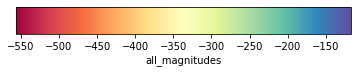

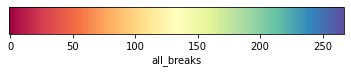

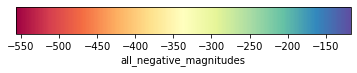

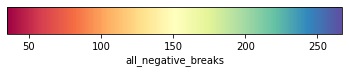

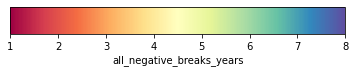

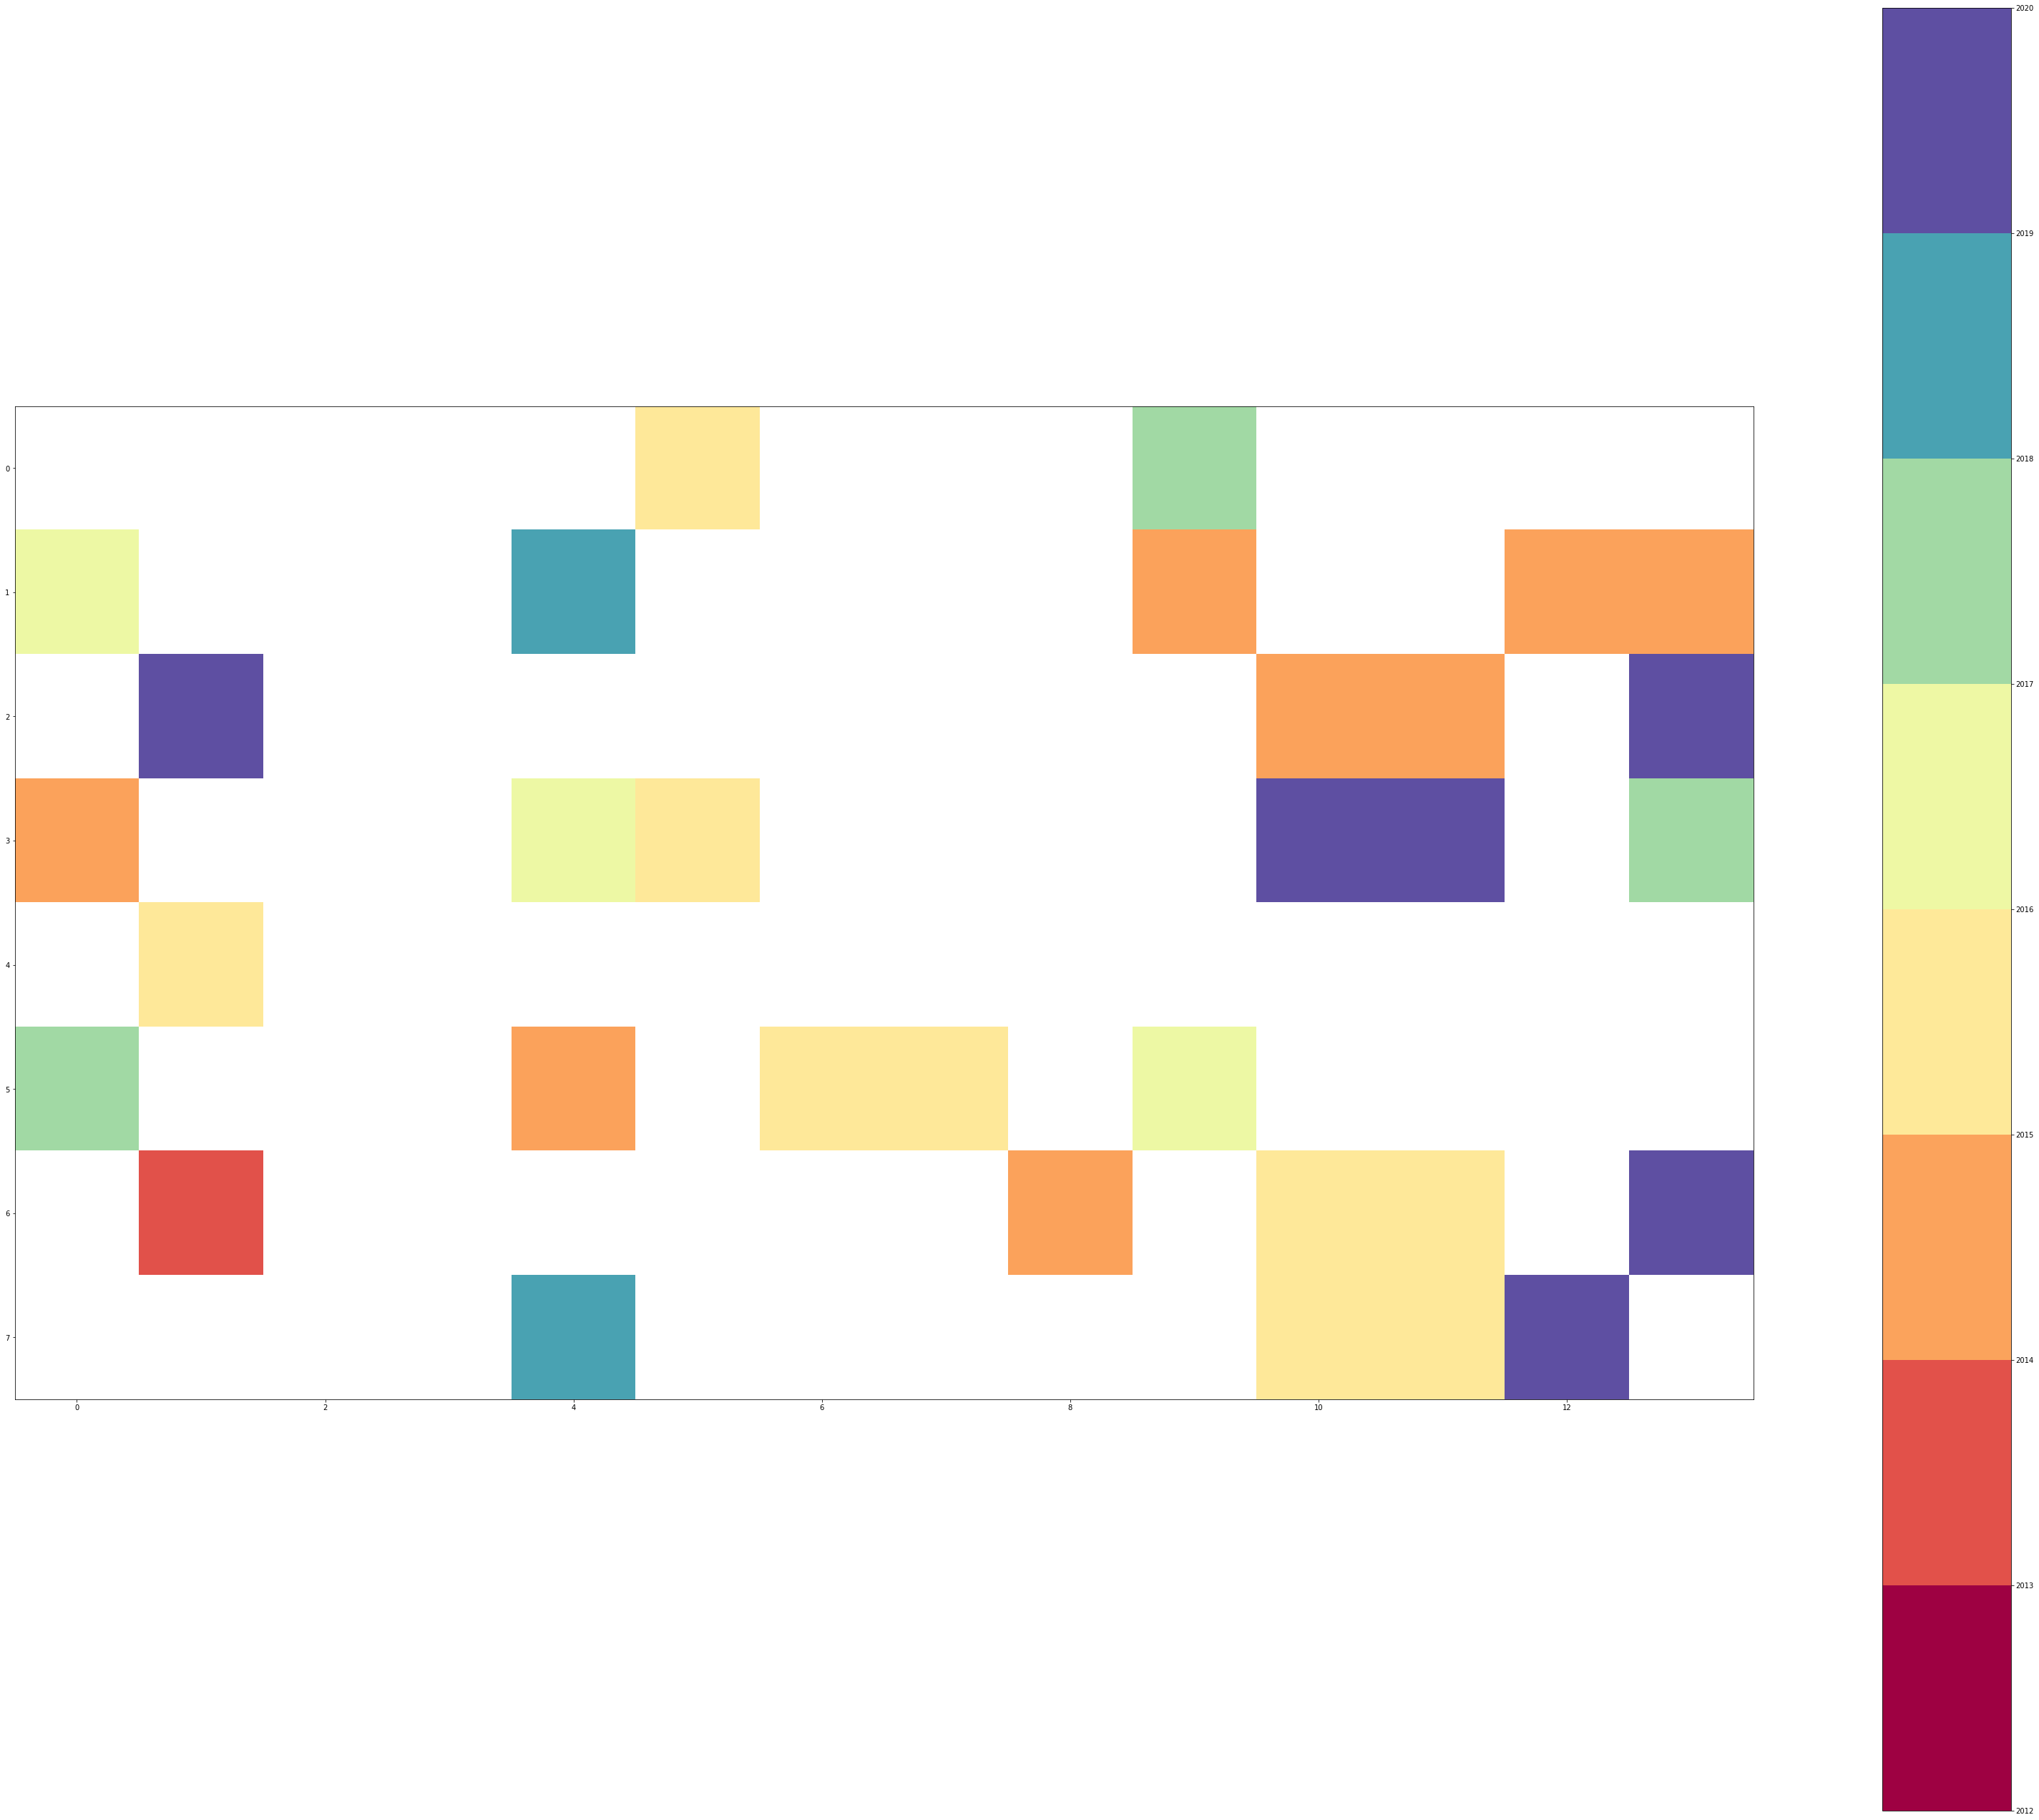

min_lat  40.701497713586164
max_lat  40.701497713586164
min_lon  -8.420088821109099
max_lon  -8.420088821109099


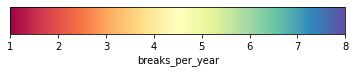

In [16]:
for data_list in run_dict:
    save_location = base_output_dir + "/" + data_list
    
    for tile in run_dict[data_list]:
        tile.check_arrays(min_perc_lacking_data = 50)
    
    if len(run_dict[data_list]) > 1:
        means, breaks = merge_tiles(run_dict[data_list],output_dir_name = save_location)
    else:
        means = run_dict[data_list][0].means_array
        breaks = run_dict[data_list][0].breaks_array
    
    save_plot(means, save_location, save_name = "all_magnitudes")
    save_plot(breaks, save_location, save_name = "all_breaks")
    
    # select only negative magnitudes
    no_breaks_indices = (breaks == -1)
    means[no_breaks_indices] = np.nan
    means[means > 0] = np.nan # only want negative mean changes

    breaks_plot = breaks.astype(np.float)
    breaks_plot[breaks == -2] = np.nan
    breaks_plot[breaks == -1] = np.nan
    breaks_plot[means >= 0] = np.nan

    save_plot(means, save_location, save_name = "all_negative_magnitudes")
    save_plot(breaks_plot, save_location, save_name = "all_negative_breaks")

    dates_monitor = []
    dates = run_dict[data_list][0].cropped_dates

    # collect dates for monitor period
    for i in range(len(dates)):
        if start_monitor <= dates[i]:
            dates_monitor.append(dates[i])
    dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period
    
    breaks_plot_years, idx_starts, ticklist = classify_output(start_monitor,end_monitor,breaks_plot,dates_array)
    #save_plot(breaks_plot_years, save_location, save_name = "all_negative_breaks_years")
    
    plot_output_matplotlib(idx_starts,breaks_plot_years,ticklist)
    #save_plot(breaks_plot_years, save_location, save_name = "breaks_per_year")
    
    set_corners(save_location, run_dict[data_list])
    
    
    

In [17]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', index=1, layout=Layout(height='auto', width='500px'…

In [18]:
m = merge_plots(data_list = run_dict[data_list], base_output_dir=base_output_dir,plot_name=plot_display_data_chooser.result + ".png")
m.save(output_dir + "/" + output_directory_chooser.result + "_" + plot_display_data_chooser.result + ".html")
m

Portugal_small_1
1
